##**Introduction**
My problem statement  was a kaggle competition which is organized by Booz Allen Hamilton  company on Kaggle. Booz Allen Hamilton has been solving for business, government, and military leaders for over 100 years. Most flite related fatalities originate from lack of airplane state awareness.That implies  ineffective attention management on part of pilots who may be distracted , sleepy or in other dangerous cognitive states.Our challenge is to build a model to detect troubling events from aircrew’s physiological data

##**Dataset features Analysis** 


I want separate features as into general and sensor based features for convenience.
Given dataset consist 6 general features like  id,experiment,crew,time, seat,event and 23 sensor based recordings among them 20 brain activities signal recordings ,1 Electrocardiogram signal recordings,1 Respiration sensor recordings  ,1 Galvanic Skin Response sensor 

***General features*** 

1. id - A unique identifier for a crew + time combination. You must predict probabilities for each id.
2. crew - a unique id for a pair of pilots. There are 9 crews in the data.
experiment - One of CA, DA, SS or LOFT. The first 3 comprise the training set. The latter is the test set.
3. time - seconds into the experiment
4. event - The state of the pilot at the given time: one of A = baseline, B = SS, C = CA, D = DA
5. seat - is the pilot in the left (0) or right (1) seat

***Sensors based features*** 
1. eeg prefix are electroencephalogram recordings(brain activity recordings)  eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,Eeg_cz,eeg_o2
2. ecg - Electrocardiogram signal. The sensor had a resolution/bit of .012215 µV and a range of -100mV to +100mV. The data are provided in microvolts.
3. r - Respiration,  a measure of the rise and fall of the chest. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.
4. gsr -  Galvanic Skin Response, a measure of electrodermal activity. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.


##**Business-Problem** 
We are provided with real physiological data from eighteen pilots who were subjected to various distracting events. The benchmark training set is a set of controlled experiments collected in a non-flight environment, outside of a flight simulator. The test set (abbreviated LOFT = Line Oriented Flight Training) consists of a full flight (take off, flight, and landing) in a flight simulator

Pilots experienced distractions intended to introduce one of following 3 cognitive states  
1. Channelized Attention (CA) is, roughly speaking, the state of being focused on one task to the exclusion of all others. This is induced in benchmarking by having the subjects play an engaging puzzle-based video game.
2. Diverted Attention (DA) is the state of having one’s attention diverted by actions or thought processes associated with a decision. This is induced by having the subjects perform a display monitoring task. Periodically, a math problem showed up which had to be solved before returning to the monitoring task.
3. Startle/Surprise (SS) is induced by having the subjects watch movie clips with jump scares.
Our aim is to build a model that can predict the state of the mind of the pilot in real time using the given psychological data by running calculations in real time to monitor the cognitive states of pilots which could help pilots to be alert when they enter a trouble state so that we can prevent accidents 


##**ML Formulation of Business Problem**
This is a Multiclass classification(A,B,C,D) problem. For each id , we need to predict the probability of each state  of the pilot at the given time. one of A = baseline, B = SS, C = CA, D = DA  

##**Fetching Data**

In [ ]:
                                           
#https://stackoverflow.com/questions/24617356/sklearn-sgdclassifier-partial-fit  

from google.colab import files
from datetime import datetime    


import pandas as pd                                                                         # basic imports 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.utils import resample 
from imblearn.over_sampling import SMOTE,RandomOverSampler,RandomUnderSampler   
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.model_selection import train_test_split                                        # sampling lib
from sklearn.preprocessing import StandardScaler,normalize,MinMaxScaler 

from sklearn.metrics import log_loss,auc,roc_auc_score,ConfusionMatrixDisplay,plot_confusion_matrix,f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC                                                                  # models
import xgboost as xgb
import lightgbm as lgb

from scipy import stats                                                        
import pylab   
import pickle
import tqdm
from tqdm import tqdm
from IPython.display import Image

In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install kaggle
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c 'reducing-commercial-aviation-fatalities' 


 99% 1.65G/1.67G [00:14<00:00, 122MB/s]
100% 1.67G/1.67G [00:14<00:00, 122MB/s]
 61% 25.0M/41.2M [00:00<00:00, 133MB/s]
100% 41.2M/41.2M [00:00<00:00, 137MB/s]
 99% 429M/435M [00:06<00:00, 49.1MB/s]
100% 435M/435M [00:06<00:00, 71.8MB/s]


In [ ]:
!unzip /content/train.csv.zip 

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
!unzip /content/test.csv.zip  

Archive:  /content/test.csv.zip
  inflating: test.csv                


In [ ]:
#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type                       
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: 
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [ ]:
train_df = import_data('/content/train.csv')

Memory usage of dataframe is 1039.79 MB
Memory usage after optimization is: 241.38 MB
Decreased by 76.8%


In [ ]:
test_df = import_data('/content/test.csv')

Memory usage of dataframe is 3837.77 MB
Memory usage after optimization is: 942.31 MB
Decreased by 75.4%


In [ ]:
train_df.isnull().sum()  # there is no null  values in train data 

crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
event         0
dtype: int64

##**EDA**

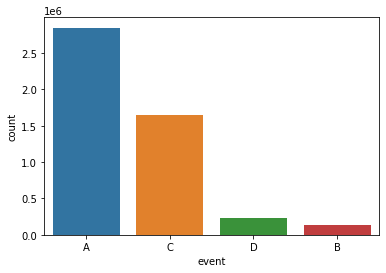

In [ ]:
# is the dataset balanced or imbalanced ?

sns.countplot(x =df.event)

count plot of target variable (event)

observations: A=baseline,B=surprisestate,C=ChanelizedAttention, D=Distractive Attention .class A samples are more compared to others.class B have very fewer samples compared to others.means more pilots are baseline condition less pilots are in surprise condition(SS) and DIstractive Attention(DA) 


conclusion : we see that given dataset is imbalanced dataset with baseline condition as majority class




###***experiment & crew & seat***

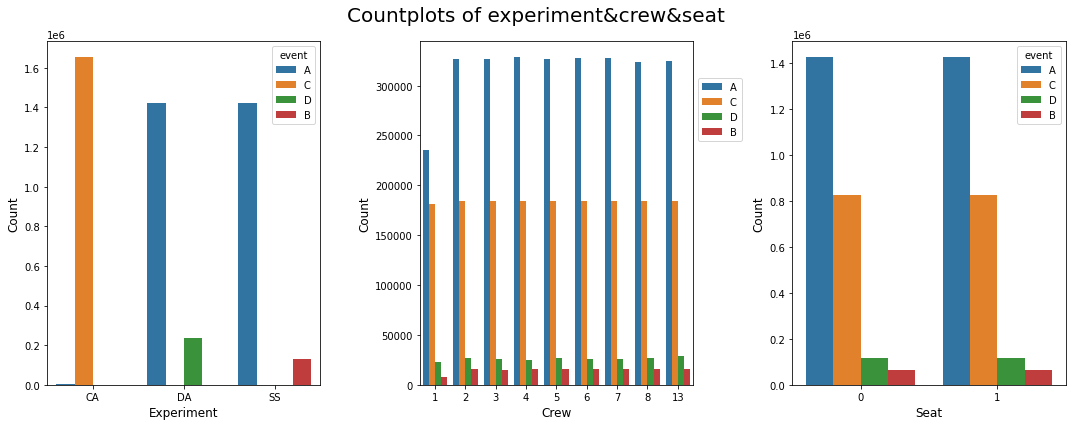

In [ ]:
# how are the samples count for each class with respect to feature categories ? 

fig =plt.figure(figsize=(15,6))    
plt.subplot(1,3,1)
sns.countplot(x=train_df.experiment,hue=train_df.event)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Experiment", fontsize=12)



plt.subplot(1,3,2)
sns.countplot(x=train_df.crew,hue=train_df.event)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Crew", fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8));



plt.subplot(1,3,3)
sns.countplot(x=train_df.seat,hue=train_df.event)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Seat", fontsize=12)


plt.tight_layout()

fig.subplots_adjust(top=0.9)

fig.suptitle('Countplots of experiment&crew&seat',fontsize=20)

plt.show()

count plots of  features experiment ,crew , seat respectively

observations:experiments conducted in DistractiveAttention(DA),SurpriseState(SS)  are few  which implies reason for imbalance.first crew pilots  seems to be small  compared to others.numver of pilots in each crew except first crew and number of pilots in each seat are same.

conclusions:imbalance occured dur to experments conducted for SS,DA are few. number of pilots in each seat and crew are same with a same distribution

Text(0.5, 0.98, 'Scatterplot of Experiment')

<Figure size 1008x864 with 0 Axes>

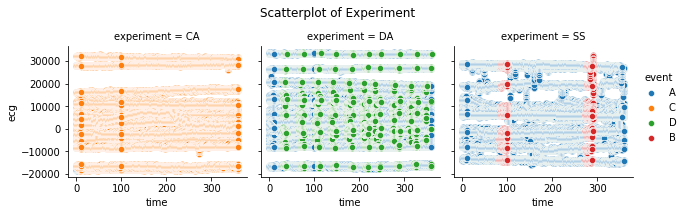

In [ ]:
plt.figure(figsize=(14,12))

g = sns.FacetGrid(train_df, col="experiment", hue="event")
g.map_dataframe(sns.scatterplot, x="time", y="ecg") 
g.add_legend()



g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Scatterplot of Experiment',fontsize=12)

plt.show()



scatterplot of experiment 

observations :all pilots gone through experiment CA(ChanelizedAttention) are classified as class c(CA) no other states.pilots gone through experiment DA(Distractive Attention) are mostly classified as class D(DA) 

conclusion : the piilots who gone through experiment CA are most likely to be in channelized attention state 


###***time feature***

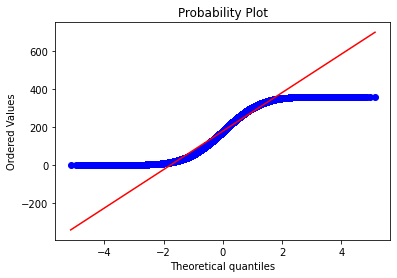

In [ ]:
stats.probplot(train_df.time,dist='norm',plot=pylab) # does the feature follow normal distribution ...?
pylab.show()

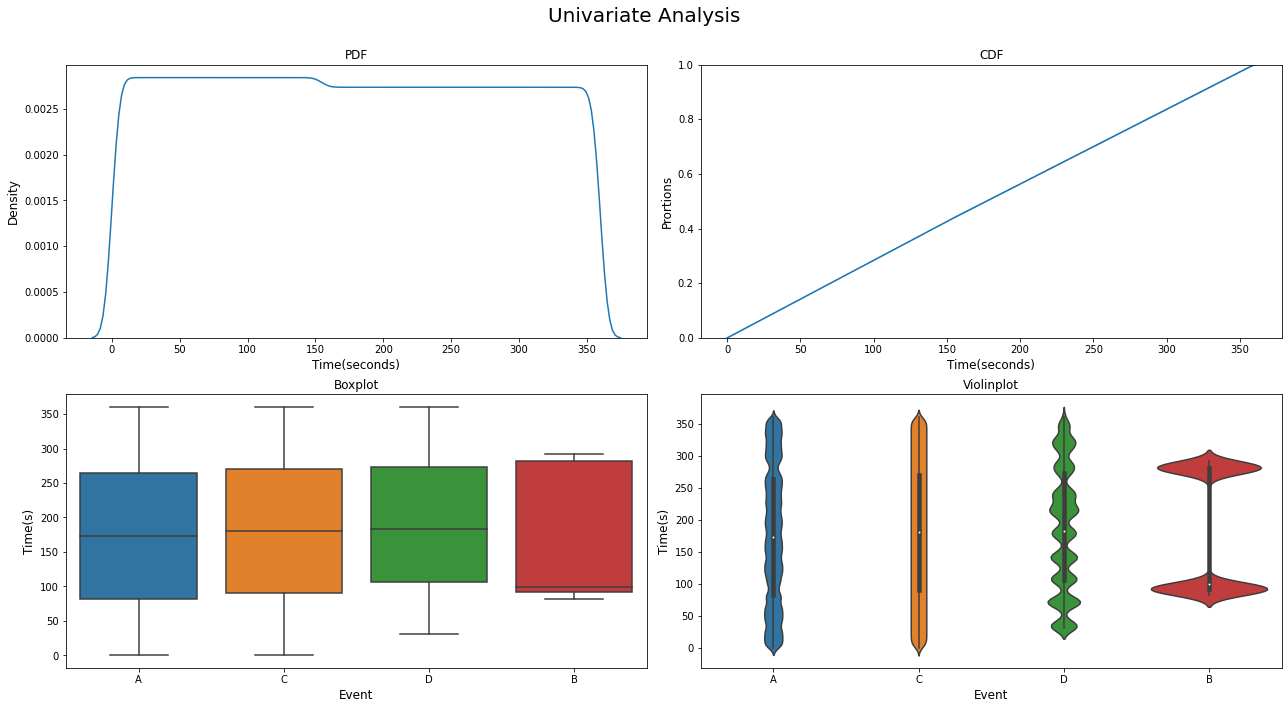

In [ ]:
fig =plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.kdeplot(data=train_df,x='time')
plt.ylabel("Density", fontsize=12)
plt.xlabel("Time(seconds)", fontsize=12)
plt.title('PDF')


plt.subplot(2,2,2)
sns.ecdfplot(data=train_df,x='time',)
plt.ylabel("Prortions", fontsize=12)
plt.xlabel("Time(seconds)", fontsize=12)
plt.title('CDF')


plt.subplot(2,2,3)
sns.boxplot(x=train_df.event,y=train_df.time)
plt.ylabel("Time(s)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title('Boxplot')

plt.subplot(2,2,4)
sns.violinplot(x='event', y='time', data=train_df)
plt.ylabel("Time(s)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title('Violinplot')


plt.tight_layout()

fig.subplots_adjust(top=0.9)

fig.suptitle('Univariate Analysis of time',fontsize=20)

plt.show()

pdf,cdf,boxplot,violinplot  of time feature 

observations: time feature values ranges from 0 to 350 seconds.no outliers present.from both boxplot and distplot we can observe that time feature separetes class B(SS) from other class which will be very usefull for classification

conclusions: being in suprise state takes more time compared to other states 

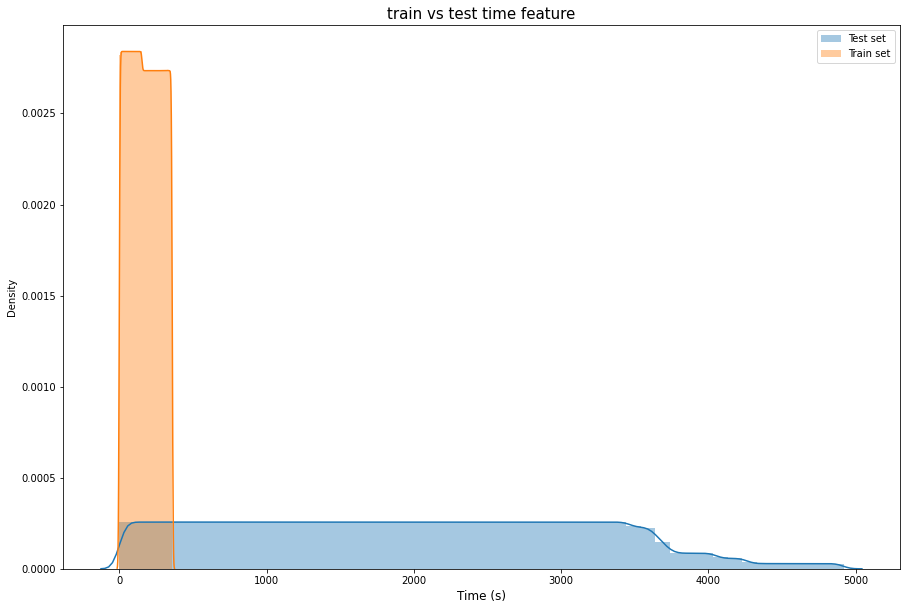

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,10))                                                        # train data vs test data   ===> time feature 
sns.distplot(test_df['time'], label='Test set')
sns.distplot(train_df['time'], label='Train set')
plt.legend()
plt.xlabel("Time (s)", fontsize=12)
plt.title("train vs test time feature", fontsize=15)
plt.show()

However,train and test distribution of time are very different.we can't use this feature because time in the flight simulator has nothing to do with time in the experiments

###***eeg features***

In [ ]:
eeg_features = ['eeg_fp1', 'eeg_f7', 'eeg_f8','eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2']

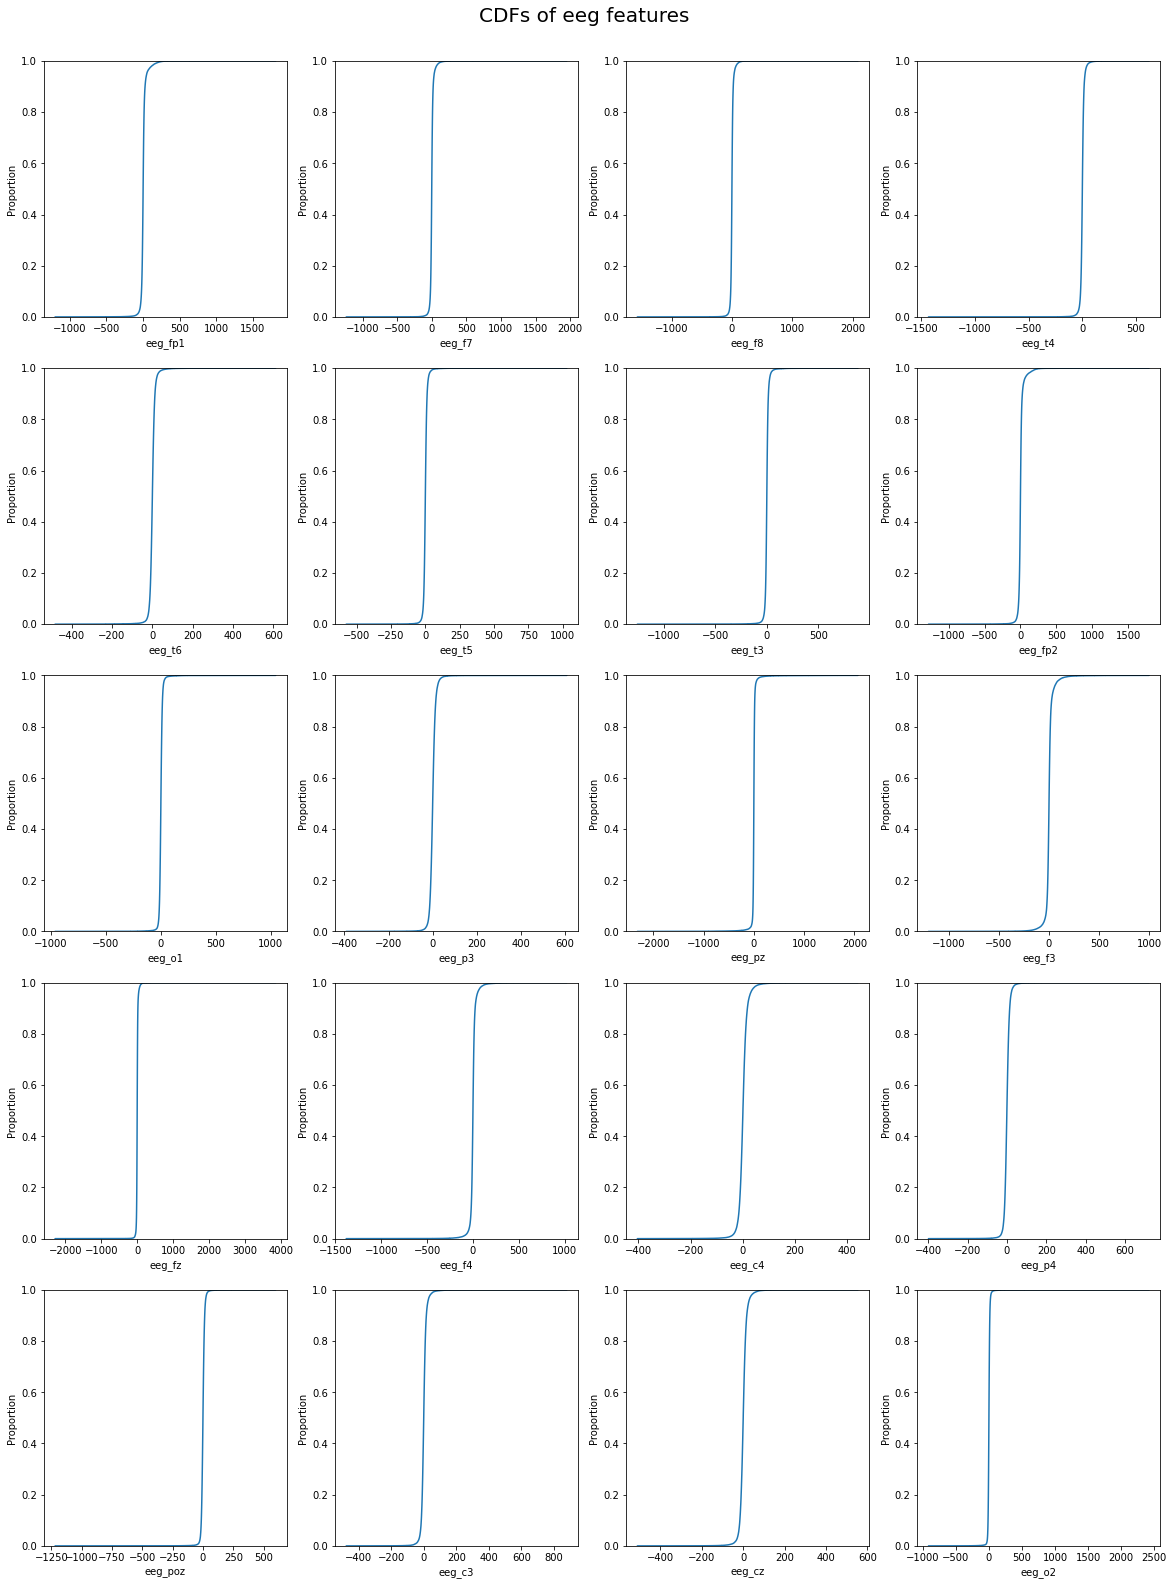

In [ ]:
fig = plt.figure(figsize=(20,25))
i = 0

for eeg in eeg_features: 
    i += 1
    plt.subplot(5, 4, i)
    sns.ecdfplot(data=train_df.sample(50000),x=eeg)

fig.subplots_adjust(top=0.95)
fig.suptitle('CDFs of eeg features',fontsize=20)

plt.show()

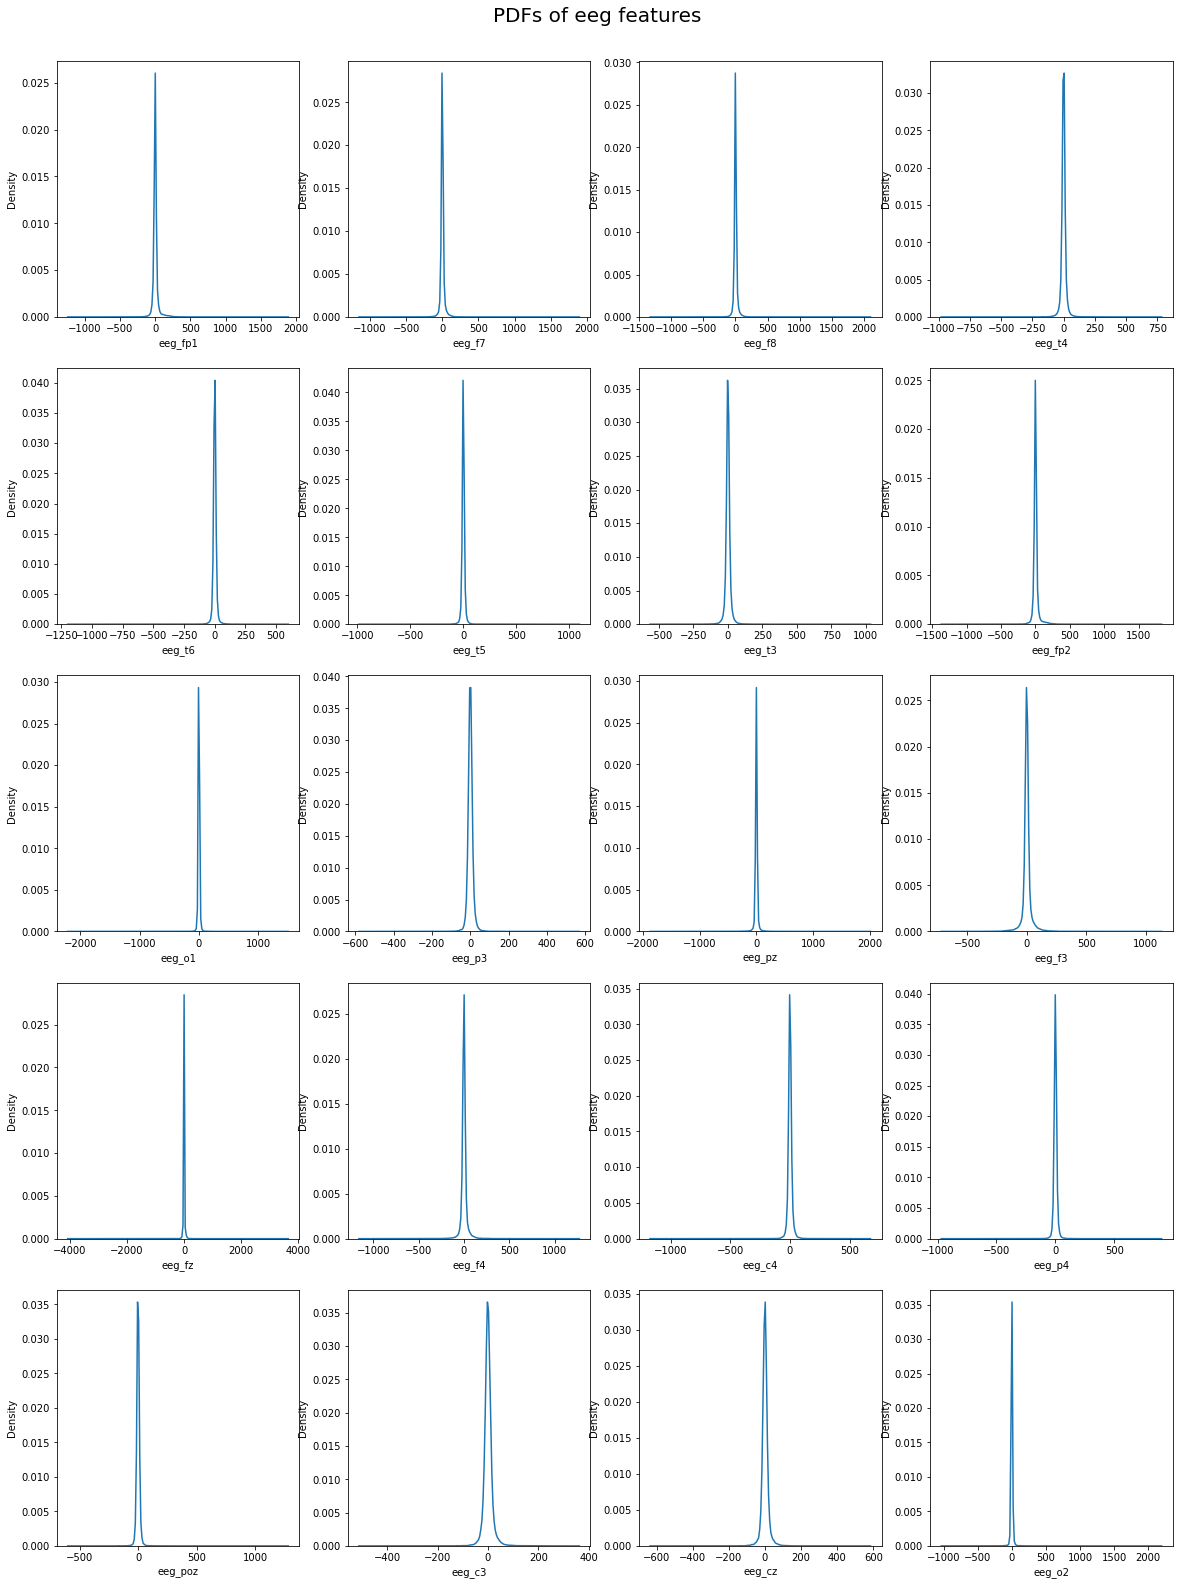

In [ ]:
fig = plt.figure(figsize=(20,25))
i = 0

for eeg in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(x=eeg ,data=train_df.sample(50000))

fig.subplots_adjust(top=0.95)
fig.suptitle('PDFs of eeg features',fontsize=20)

plt.show()

from both cdf and pdf of feautures we can say that most of eeg values are zero centered.


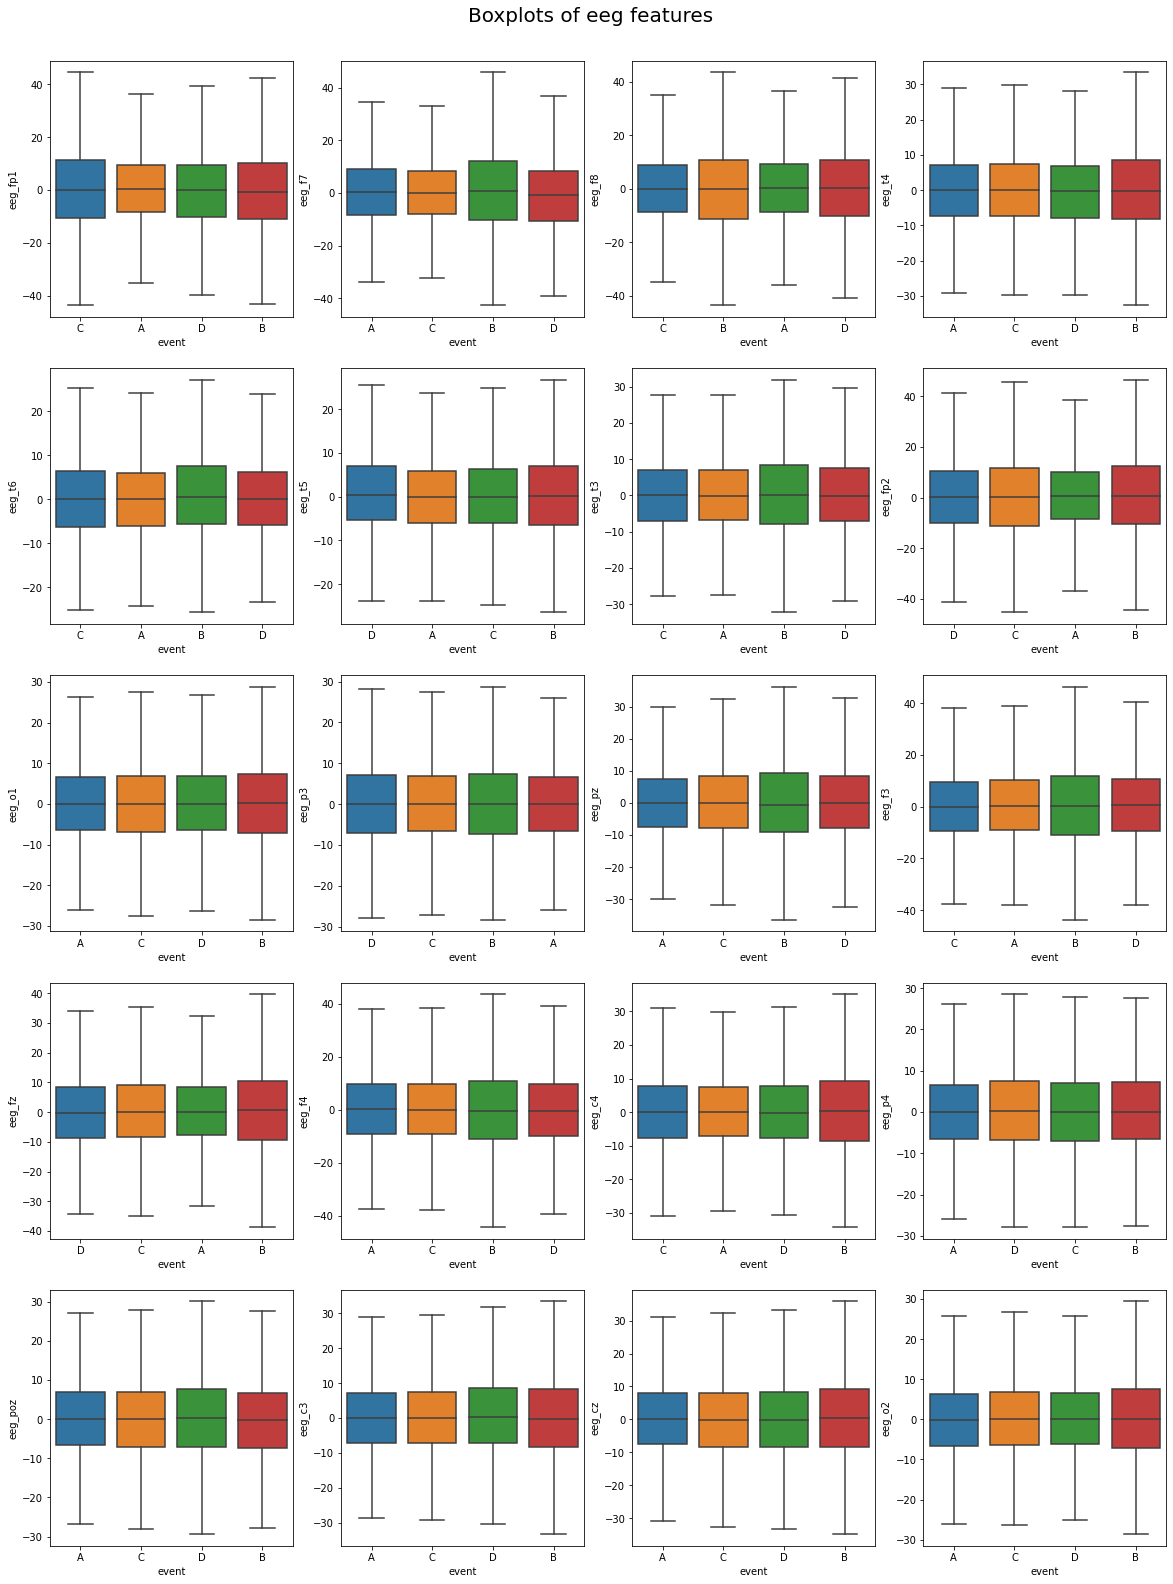

In [ ]:
fig = plt.figure(figsize=(20,25))
i = 0
                                                 # taking 50000 samples 
for eeg in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.boxplot(x='event', y=eeg, data=train_df.sample(50000), showfliers=False)

fig.subplots_adjust(top=0.95)
fig.suptitle('Boxplots of eeg features',fontsize=20)

plt.show()

pdf,cdf,boxplots  of eeg features 

observations: eeg feature values ranges from -1500 to 2000 micro volts.by observing pdf,cdf,boxplots we say that all feaures are more similar .so all of them are highly correlated with each others

conclusion: all features explaining same information in  eeg features. so using eeg raw features of no use

###**ecg feature**

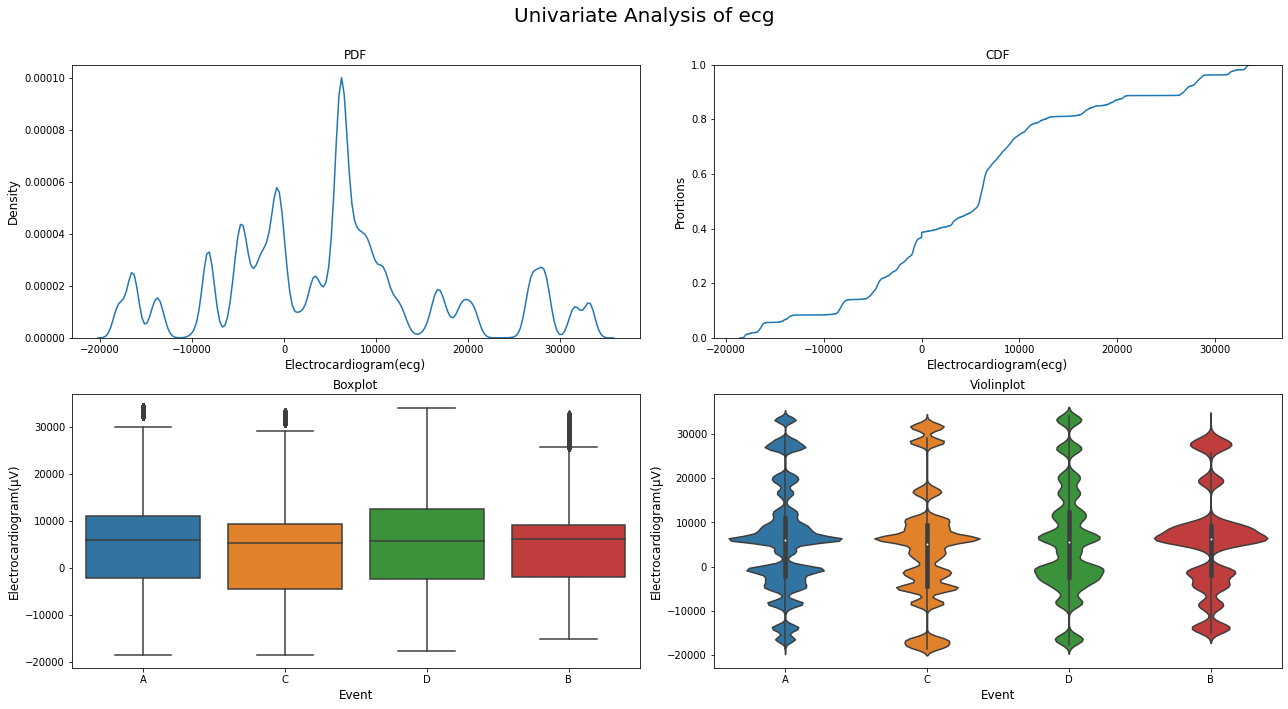

In [ ]:
fig = plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.kdeplot(data=train_df,x='ecg')
plt.ylabel("Density", fontsize=12)
plt.xlabel("Electrocardiogram(ecg)", fontsize=12)
plt.title('PDF')


plt.subplot(2,2,2)
sns.ecdfplot(data=train_df,x='ecg',)
plt.ylabel("Prortions", fontsize=12)
plt.xlabel("Electrocardiogram(ecg)", fontsize=12)
plt.title('CDF')


plt.subplot(2,2,3)
sns.boxplot(x=train_df.event,y=train_df.ecg)
plt.ylabel("Electrocardiogram(µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title('Boxplot')

plt.subplot(2,2,4)
sns.violinplot(x='event', y='ecg', data=train_df)
plt.ylabel("Electrocardiogram(µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title('Violinplot')


plt.tight_layout()

fig.subplots_adjust(top=0.9)

fig.suptitle('Univariate Analysis of ecg',fontsize=20)

plt.show()

pdf,cdf,boxplot violinplots of ecg feature

observations:    
ecg feature have some outliers in which class B data have more outliers.if ecg values are very high i.e greater than 10000 micro volts more likely to classify as class D(DA).if ecg values are very low more likely to classify as C(CA)

conclusion:    
ecg feature usefull in classifying classes CA and DA

---



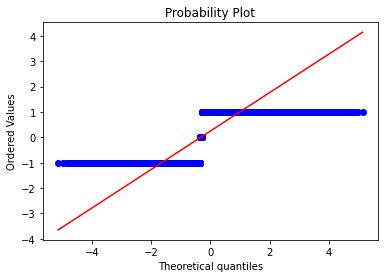

In [ ]:
stats.probplot(train_df.ecg,dist='norm',plot=pylab) # does feature follow normal distribution 
pylab.show()

###***respiration(r)***

respiration is  measure of the rise and fall of the chest. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.

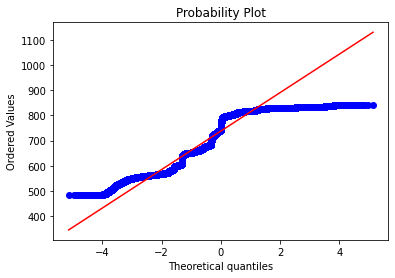

In [ ]:
stats.probplot(train_df.r,dist='norm',plot=pylab) 
pylab.show()

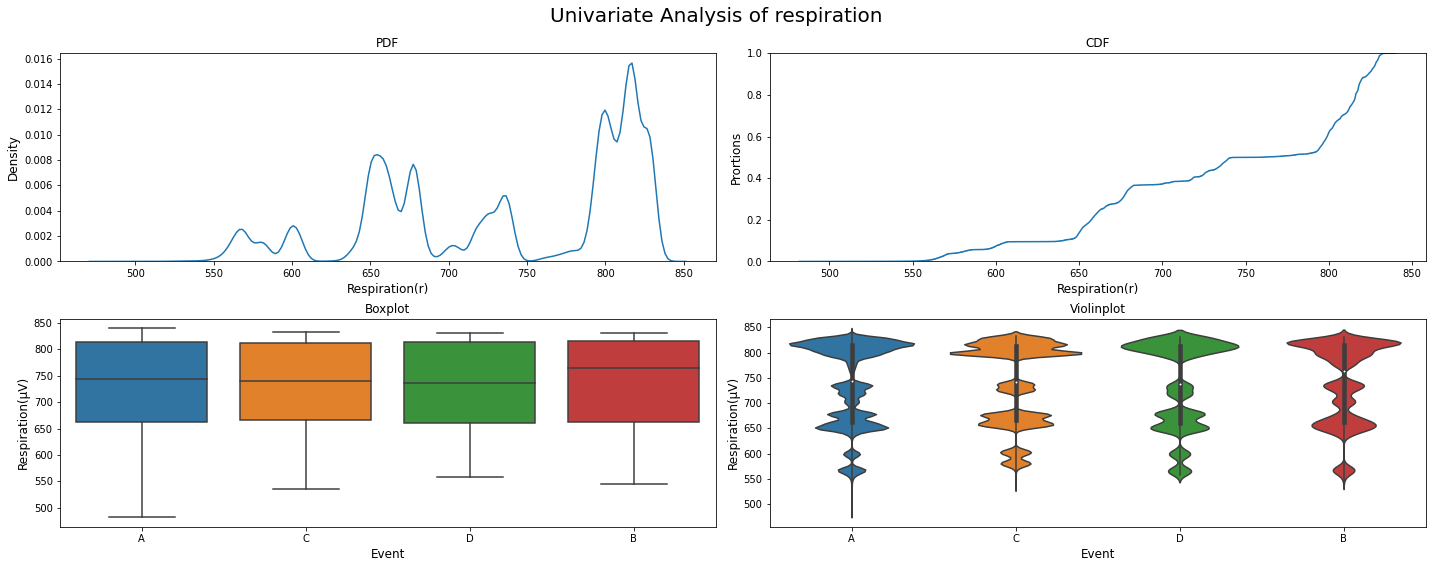

In [ ]:
fig = plt.figure(figsize=(20,8))                                                         # how much role does respiration play for classifying..?

plt.subplot(2,2,1)
sns.kdeplot(data=train_df,x='r')
plt.ylabel("Density", fontsize=12)
plt.xlabel("Respiration(r)", fontsize=12)
plt.title('PDF')


plt.subplot(2,2,2)
sns.ecdfplot(data=train_df,x='r',)
plt.ylabel("Prortions", fontsize=12)
plt.xlabel("Respiration(r)", fontsize=12)
plt.title('CDF')


plt.subplot(2,2,3)
sns.boxplot(x=train_df.event,y=train_df.r)
plt.ylabel("Respiration(µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title('Boxplot')

plt.subplot(2,2,4)
sns.violinplot(x='event', y='r', data=train_df)
plt.ylabel("Respiration(µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title('Violinplot')


plt.tight_layout()

fig.subplots_adjust(top=0.9)

fig.suptitle('Univariate Analysis of respiration',fontsize=20)

plt.show()

boxplot , histplot of respiration feature

observations: quantiles of all classes of feature are almost same. pdf of r also very overlapping. no outliers present in data 

conclusion: not much useful for classification if we use this raw respiration

###***galvanic-skin-rate(gsr)***

A measure of electrodermal activity. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.

galvanic skin rate refers to changes in sweat gland activity that are reflective of the intensity of our emotional state, otherwise known as emotional arousal.

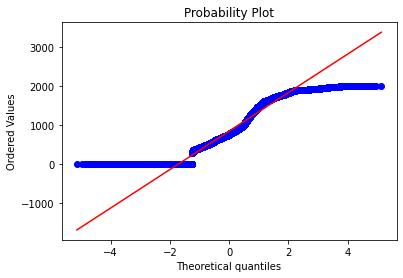

In [ ]:
stats.probplot(train_df.gsr,dist='norm',plot=pylab)  # does the feature follow gaussian distribution
pylab.show()

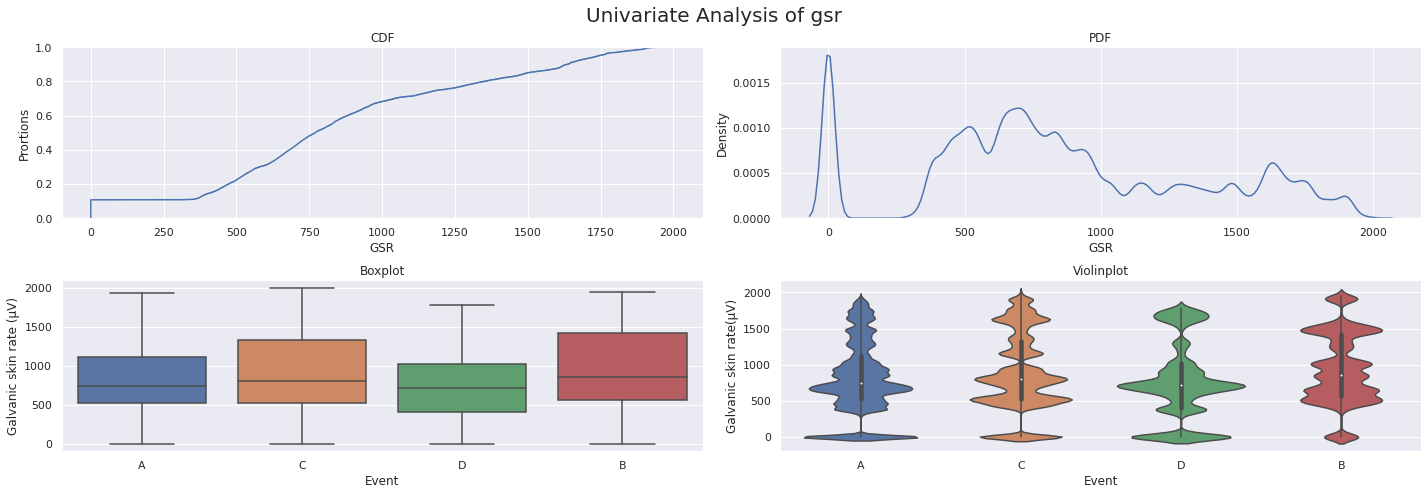

In [ ]:
fig = plt.figure(figsize=(20,7))                                                        # does gsr usefull in classifying ..?

plt.subplot(2,2,2)
sns.kdeplot(data=train_df,x='gsr')
plt.ylabel("Density", fontsize=12)
plt.xlabel("GSR", fontsize=12)
plt.title('PDF')

plt.subplot(2,2,1)
sns.ecdfplot(data=train_df,x='gsr',)
plt.ylabel("Prortions", fontsize=12)
plt.xlabel("GSR", fontsize=12) 
plt.title('CDF')

plt.subplot(2,2,3)
sns.boxplot(x=train_df.event,y=train_df.gsr)
plt.ylabel("Galvanic skin rate (µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title('Boxplot')

plt.subplot(2,2,4)
sns.violinplot(x='event', y='gsr', data=train_df)
plt.ylabel("Galvanic skin rate(µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title('Violinplot')


plt.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Univariate Analysis of gsr',fontsize=20)
plt.show()

boxplot ,distplot of gsr(galvanic skin response) feature 

observations: values of gsr ranges from 0 to 2000 micro volts. if  gsr values are very high. more likely to be surprisestate B (SS) and  gsr values are low.more chances of being classified as D (DA).

conclusion:  gsr feature useful for separating classB and class D


 



###***correlations***

In [ ]:
corr = train_df.corr(method='spearman')                                     # usng spearman correlations 

In [ ]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)                           

Text(0.5, 1.0, 'Spearman rank Correlations')

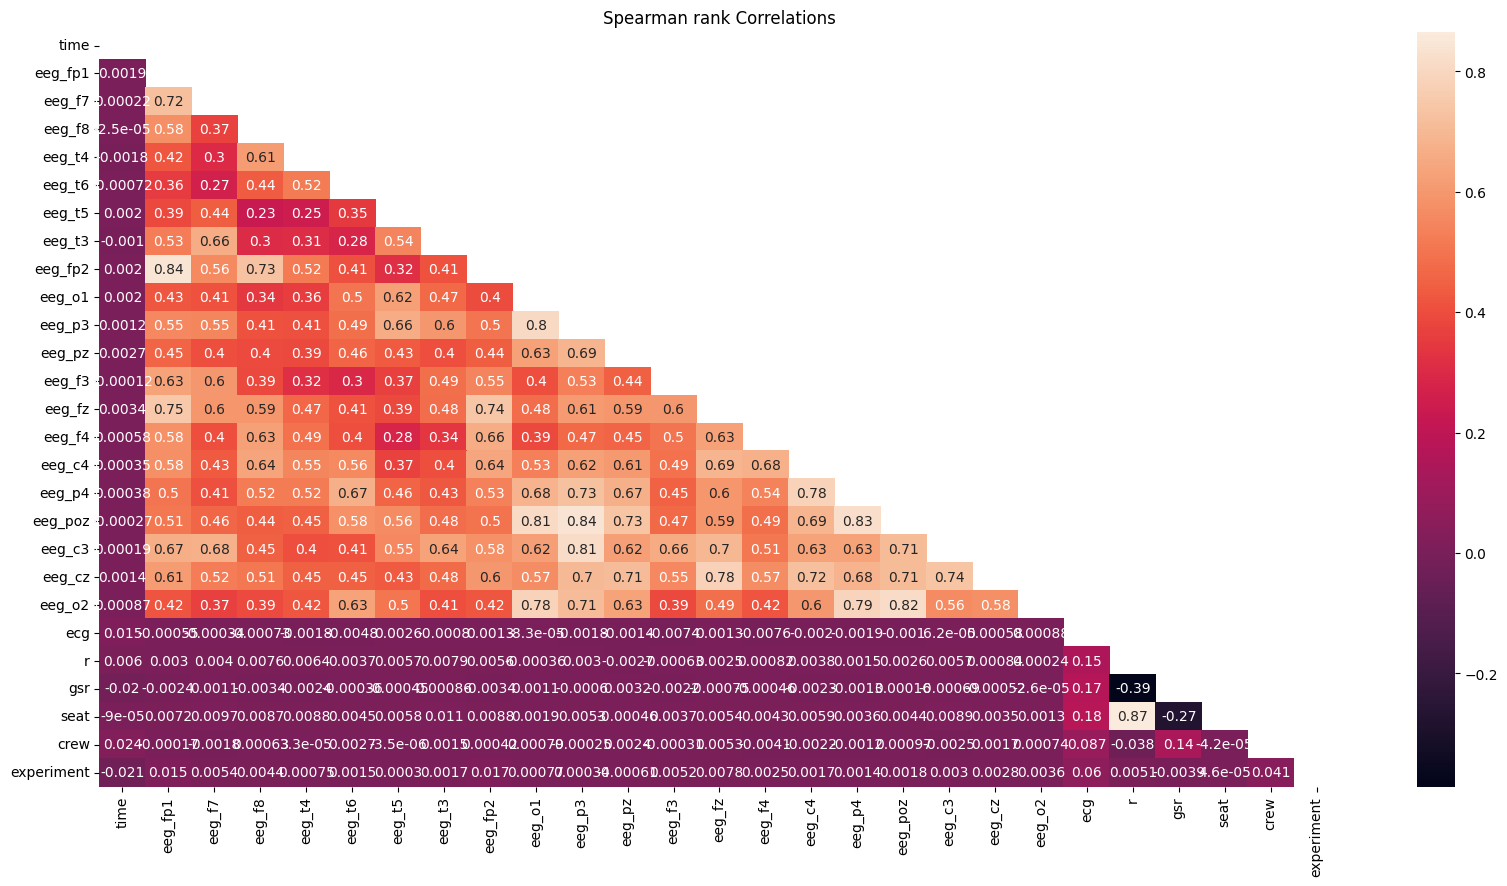

In [ ]:
# how are the feature correlations ..?

plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(corr,annot=True,mask=matrix)
plt.title('Spearman rank Correlations')

heatmap of all features 

observations: all dark regoins represent less correlated more chances of being independent i.e features doesn't share informatin .all light regions represent more correlated more chances of being dependent i.e features does share information with each other. we see that all brain activity sensorbased featues are more correlated than other features that implies they are sharing same information. time feature correlations with other all features are very low 

conclusion : rather using all brain activity sensor features better to use some of them which having more variance 


##**Performance Metric**

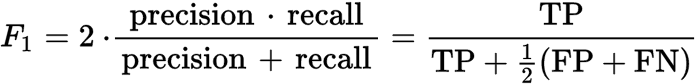


 F1 score values ranges from 0 to 1

 F1-score is 1.0, indicating perfect precision and recall, and 
 
 the lowest possible value is 0, if either the precision or the recall is zero


i prefered f1-score because there is much imbalance in the classes as i seen in the EDA. f1 score is hormonic mean of precision and recall . so it effects precision and recall . our case we need to less missclassifications in  minority classes i.e recall should be very high for minority classes  


f1 score  can be calculated using 2 methods 

if it is 2 classe-classification

True positive (TP1) 

False positive (FP1)

False negative (FN1)


True positive (TP2) 

False positive (FP2) 

False negative (FN2) 

1. **Micro Avg Method:** 
                    Micro-average of precision=(TP1+TP2)/(TP1+TP2+FP1+FP2)


                        Micro-average of recall=(TP1+TP2)/(TP1+TP2+FN1+FN2)

The Micro-average F-Score will be simply the harmonic mean of these two


In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets and the apply them to get the statistics

micro-average can be a useful measure when your dataset varies in size.

2. **Macro Avg Method:**    

                    P1 = TP1/TP1+FP1 and R1 =TP1/TP1+FN1


                       P2 = TP2/TP2+FP2 and R2 =TP2/TP2+FN2

The Macro-average F-Score will be simply the harmonic mean of these two


Macro F1-score will give the same importance to each label/class. It will be low for models that only perform well on the common classes while performing poorly on the rare classes.

3. **Weighted Avg Method:**    When averaging the macro-F1, we gave equal weights to each class. We don’t have to do that: in weighted-average F1-score, or weighted-F1, we weight the F1-score of each class by the number of samples from that class 
          
           


##**Feature Transformations**

In [ ]:
for i in train_df.loc[:, train_df.dtypes == np.float64].columns:  # Acceptable values of skewness fall between − 3 and + 3
  print(f'skewness of {i}',stats.skew(train_df[i]))

skewness of time 0.023713639963621594
skewness of eeg_fp1 4.4300719691736274
skewness of eeg_f7 6.627156812071795
skewness of eeg_f8 5.807174166405038
skewness of eeg_t4 0.21598616492938275
skewness of eeg_t6 0.15133824595824732
skewness of eeg_t5 2.9260593778554425
skewness of eeg_t3 4.641668063612597
skewness of eeg_fp2 5.424459216179981
skewness of eeg_o1 -8.095576619937177
skewness of eeg_p3 -0.7322388417711336
skewness of eeg_pz 1.9695019849404807
skewness of eeg_f3 1.6009746625746875
skewness of eeg_fz -12.64451519988544
skewness of eeg_f4 -0.18690127918069277
skewness of eeg_c4 0.3752346939445346
skewness of eeg_p4 -1.6026330820856993
skewness of eeg_poz 4.014209096646632
skewness of eeg_c3 0.06768709620947899
skewness of eeg_cz 0.552534354079149
skewness of eeg_o2 16.596561192358507
skewness of ecg 0.395740986656953
skewness of r -0.507197282313886
skewness of gsr 0.2555333880817635
skewness of ft2 0.40711389504159495
skewness of ft1 0.395166315384999
skewness of ft4 0.39252726

In [ ]:
for i in train_df.loc[:, train_df.dtypes == np.float64].columns:
  print(f'kurtosis of {i} ',stats.kurtosis(Ntrain[i]))                  # kurtosis is appropriate from a range of − 10 to + 10

kurtosis of time  -1.2035930268851518
kurtosis of eeg_fp1  222.19585429925684
kurtosis of eeg_f7  584.4934269387415
kurtosis of eeg_f8  665.8536680115927
kurtosis of eeg_t4  706.797934072772
kurtosis of eeg_t6  336.76465807478024
kurtosis of eeg_t5  603.2463789997947
kurtosis of eeg_t3  383.4861819168481
kurtosis of eeg_fp2  281.72940746143473
kurtosis of eeg_o1  1578.583874174124
kurtosis of eeg_p3  403.1473185693751
kurtosis of eeg_pz  316.89772786589447
kurtosis of eeg_f3  99.15164982594241
kurtosis of eeg_fz  2192.4034520121413
kurtosis of eeg_f4  241.83588596660474
kurtosis of eeg_c4  181.36781387384676
kurtosis of eeg_p4  376.01754669921434
kurtosis of eeg_poz  784.6622802383392
kurtosis of eeg_c3  215.12195505619317
kurtosis of eeg_cz  80.61163722371202
kurtosis of eeg_o2  1946.9509109112746
kurtosis of ecg  -0.10297448755397465
kurtosis of r  -1.0677643970139885
kurtosis of gsr  -0.5872840544623905
kurtosis of ft2  -0.07386138842632883
kurtosis of ft1  -0.10363717534516992
kurt

In [ ]:
train_df['eeg_fp1_t']     = np.log(train_df.eeg_fp1 + 1- np.min(train_df.eeg_fp1)  )          # https://stackoverflow.com/questions/60058552/when-i-log-transform-pandas-column-i-get-nans-should-i-replace-these-with-0
train_df['eeg_fp2_t']     = np.log(train_df.eeg_fp2 + 1 - np.min(train_df.eeg_fp2) ) 
                                                                                              # log tranforms for postively skewed values with presence of negative values 
train_df['eeg_f7_t']      = np.log(train_df.eeg_f7  + 1 - np.min(train_df.eeg_f7)) 
train_df['eeg_t3_t']      = np.log(train_df.eeg_t3  + 1 -np.min(train_df.eeg_t3))              # added  value based on features which have large negative values

train_df['eeg_f8_t']      = np.log(train_df.eeg_f8  + 1 -np.min(train_df.eeg_f8)) 
train_df['eeg_o2_t']      = np.log(train_df.eeg_o2  + 1 -np.min(train_df.eeg_o2)) 

train_df['eeg_o1_t']      = np.square(train_df.eeg_o1)                                          # square transforms for negatively skewed values with presence of negative values 
train_df['eeg_fz_t']      = np.square(train_df.eeg_fz)  
 
train_df['ft1']           = train_df.time          + train_df.ecg
train_df['ft2']           = train_df.ecg           + train_df.gsr                               # less correlated combo 
train_df['ft3']           = train_df.ecg           + train_df.r  
train_df['ft4']           = train_df.gsr           + train_df.r 

train_df['ft5']           = train_df.eeg_p3        + train_df.eeg_poz                           # highly correlated  combo 
train_df['ft6']           = train_df.eeg_fp1       + train_df.eeg_fp2
train_df['ft7']           = train_df.eeg_p4        + train_df.eeg_poz 

In [ ]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # replacing inf values to nan 

In [ ]:
train_df.isnull().sum() # null values before normalizing  

crew                0
experiment    4867421
time                0
seat                0
eeg_fp1             0
eeg_f7              0
eeg_f8              0
eeg_t4              0
eeg_t6              0
eeg_t5              0
eeg_t3              0
eeg_fp2             0
eeg_o1              0
eeg_p3              0
eeg_pz              0
eeg_f3              0
eeg_fz              0
eeg_f4              0
eeg_c4              0
eeg_p4              0
eeg_poz             0
eeg_c3              0
eeg_cz              0
eeg_o2              0
ecg                 0
r                   0
gsr                 0
event         4867421
dtype: int64

In [ ]:
train_df = train_df.dropna()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

scaler = MinMaxScaler() 
Ntrain = train_df.loc[:, train_df.dtypes == np.float64]

Ntrain[:] = scaler.fit_transform(Ntrain[:])




In [ ]:
Ntrain.isnull().sum()  # null  values after normalizing 

time         0
eeg_fp1      0
eeg_f7       0
eeg_f8       0
eeg_t4       0
eeg_t6       0
eeg_t5       0
eeg_t3       0
eeg_fp2      0
eeg_o1       0
eeg_p3       0
eeg_pz       0
eeg_f3       0
eeg_fz       0
eeg_f4       0
eeg_c4       0
eeg_p4       0
eeg_poz      0
eeg_c3       0
eeg_cz       0
eeg_o2       0
ecg          0
r            0
gsr          0
eeg_fp1_t    0
eeg_fp2_t    0
eeg_f7_t     0
eeg_t3_t     0
eeg_f8_t     0
eeg_o2_t     0
eeg_o1_t     0
eeg_fz_t     0
ft1          0
ft2          0
ft3          0
ft4          0
ft5          0
ft6          0
ft7          0
dtype: int64

In [ ]:
Ntrain['seat'] = train_df.seat
Ntrain['crew'] = train_df.crew

Ntrain['experiment'] = train_df['experiment'].map({'CA': 0, 'DA': 1,'SS':2})
Ntrain['event'] = train_df['event'].map({'A':0, 'B':1,'C':2,'D':3})

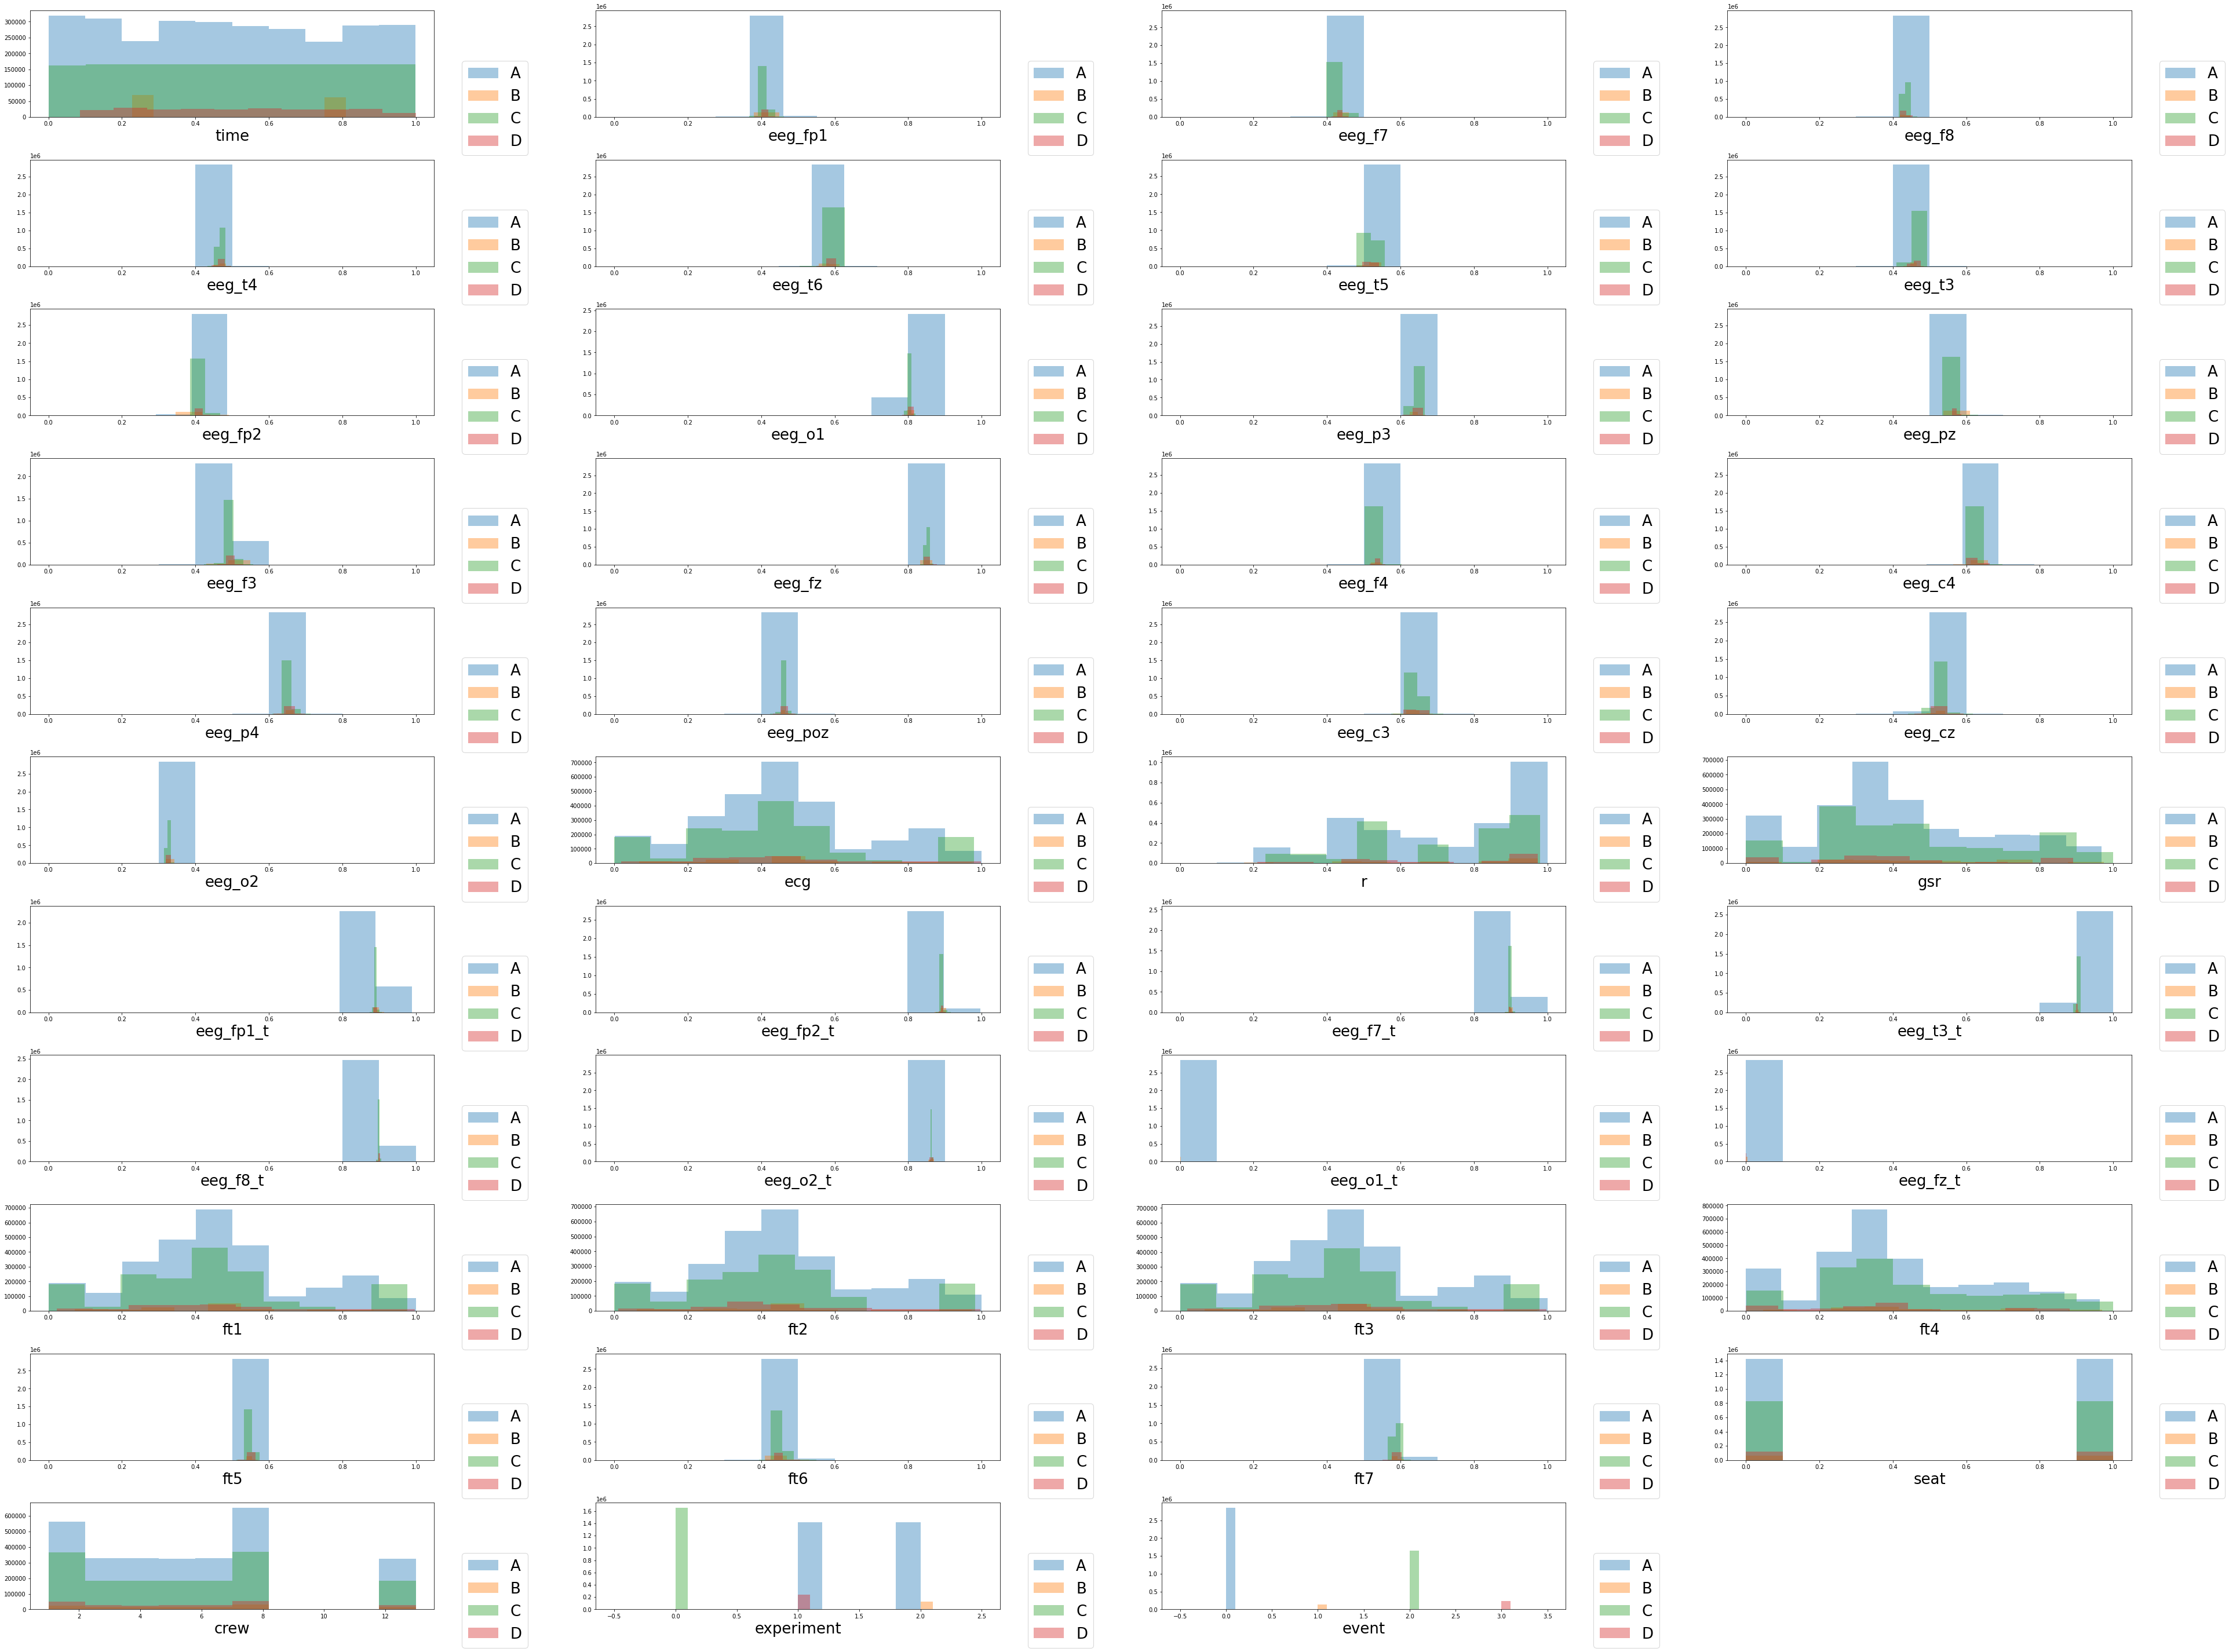

In [ ]:
trainA = Ntrain[train_df.event=='A']
trainB = Ntrain[train_df.event=='B']
trainC = Ntrain[train_df.event=='C']
trainD = Ntrain[train_df.event=='D']

fig = plt.figure(figsize=(65,65))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.grid()
                                                                                             # histograms of all features 
for row,i in zip(Ntrain,range(0,len(Ntrain.columns))):
    
    plt.subplot(len(Ntrain.columns)/3, 4, i+1)
    plt.hist(trainA[row],label='A',alpha=0.4)
    plt.hist(trainB[row],label='B',alpha=0.4)
    plt.hist(trainC[row],label='C',alpha=0.4)
    plt.hist(trainD[row],label='D',alpha=0.4)
    plt.xticks(fontsize=10)
    
    plt.xlabel(row,size=26)
    plt.legend(fontsize=26,bbox_to_anchor = (1.05, 0.6))

histplots of features 

observations:   ft1,ft2,ft3,ft4,spreads are better compared to eeg features because of adding up of time feature. in eeg_o1_t,eeg_fz_t,eeg_o2_t  features class A highlighted well compared to other classes 

conclustion some combinations seems to better





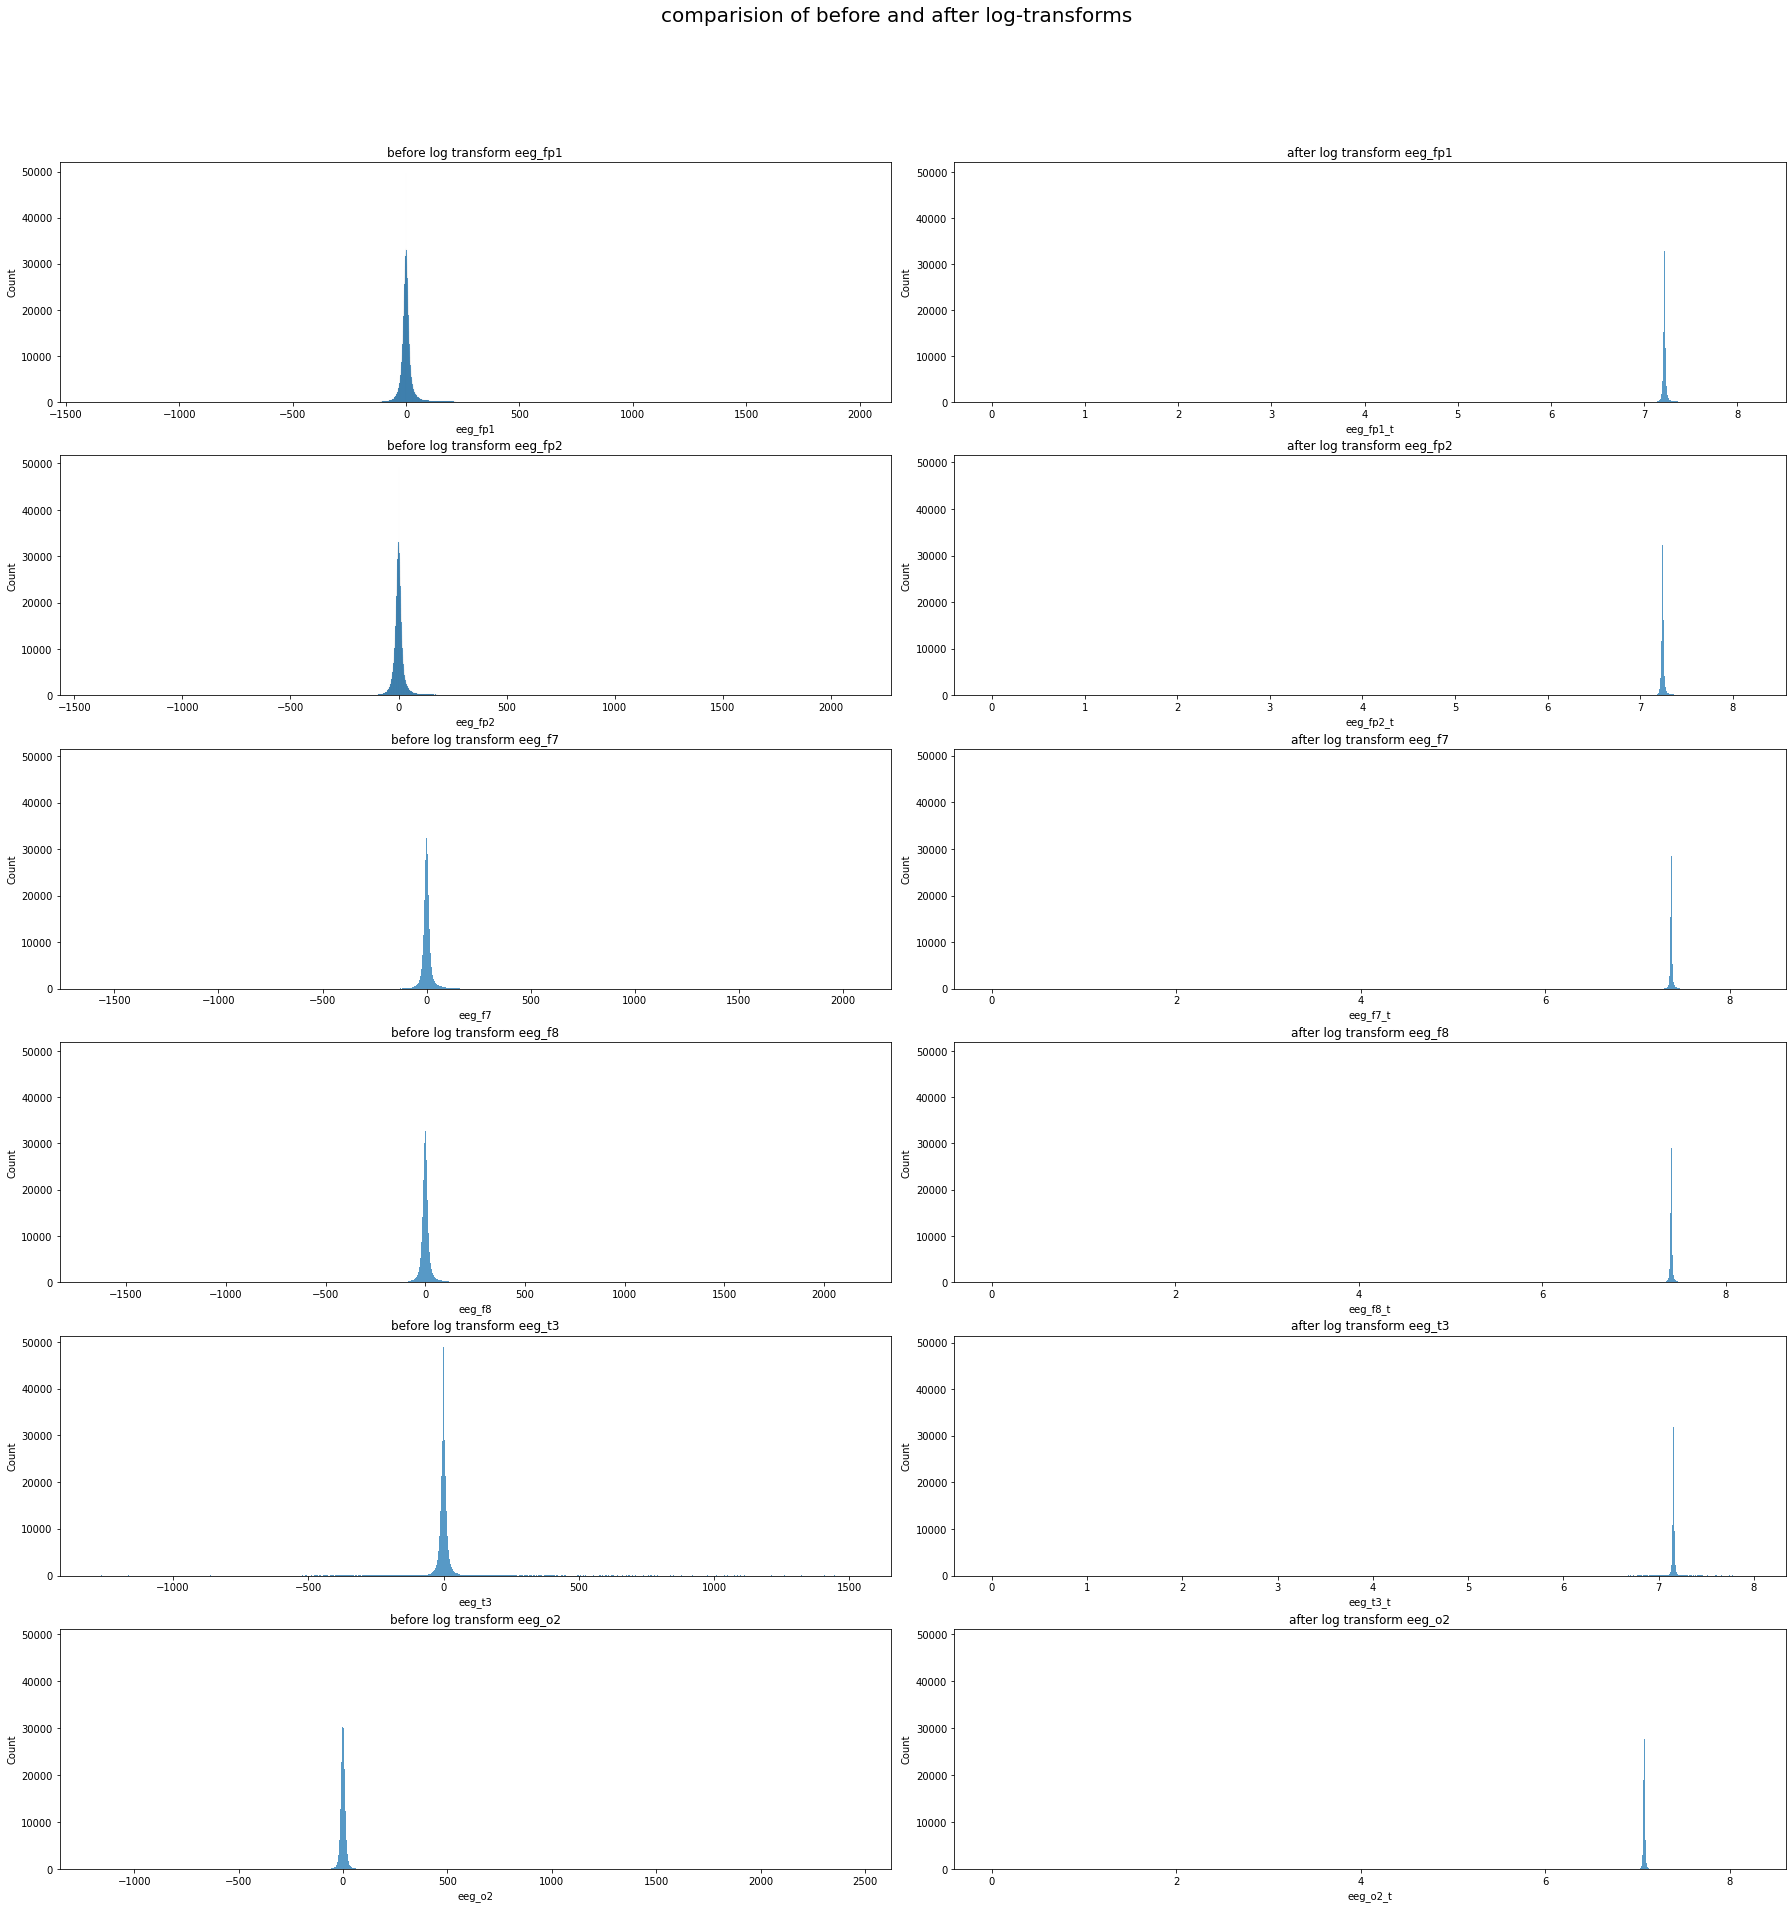

In [ ]:
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(25,27))

plt.subplot(6,2,1)
sns.histplot(x=train_df.eeg_fp1 )                   
plt.title('before log transform eeg_fp1')
plt.subplot(6,2,2)
          
sns.histplot(x=train_df.eeg_fp1_t) 
plt.title('after log transform eeg_fp1');


plt.subplot(6,2,3)                             
sns.histplot(x=train_df.eeg_fp2 )                    
plt.title('before log transform eeg_fp2')
plt.subplot(6,2,4)
             
sns.histplot(x=train_df.eeg_fp2_t) 
plt.title('after log transform eeg_fp2');


plt.subplot(6,2,5)
sns.histplot(x=train_df.eeg_f7)                    
plt.title('before log transform eeg_f7')
plt.subplot(6,2,6)
               
sns.histplot(x=train_df.eeg_f7_t) 
plt.title('after log transform eeg_f7');


plt.subplot(6,2,7)
sns.histplot(x=train_df.eeg_f8)                    
plt.title('before log transform eeg_f8')
plt.subplot(6,2,8)
             
sns.histplot(x=train_df.eeg_f8_t) 
plt.title('after log transform eeg_f8');


plt.subplot(6,2,9)
sns.histplot(x=train_df.eeg_t3)                    
plt.title('before log transform eeg_t3')
plt.subplot(6,2,10)
               
sns.histplot(x=train_df.eeg_t3_t) 
plt.title('after log transform eeg_t3');


plt.subplot(6,2,11)
sns.histplot(x=train_df.eeg_o2)                   
plt.title('before log transform eeg_o2')
plt.subplot(6,2,12)
             
sns.histplot(x=train_df.eeg_o2_t) 
plt.title('after log transform eeg_o2');

plt.tight_layout() 

fig.subplots_adjust(top=0.9)

fig.suptitle('comparision of before and after log-transforms',fontsize=20)

plt.show()

histplots of positively skewed feaures 

observations:log-transformed features changed scale of distribution but the distribution more likely similar.clearly we can observe mean and std changes which before logtransforms  are at 0.4 and after logtransforms are near at 0.7 which is due to adding larger value to avoid nan values 

conclusion:  spread of features decreaing after log transforms. so not much usefull

In [ ]:
new_features = ['eeg_fp1_t', 'eeg_fp2_t', 'eeg_f7_t', 'eeg_t3_t',
       'eeg_f8_t', 'eeg_o2_t', 'eeg_o1_t', 'eeg_fz_t', 'ft1', 'ft2', 'ft3',
       'ft4', 'ft5', 'ft6', 'ft7']

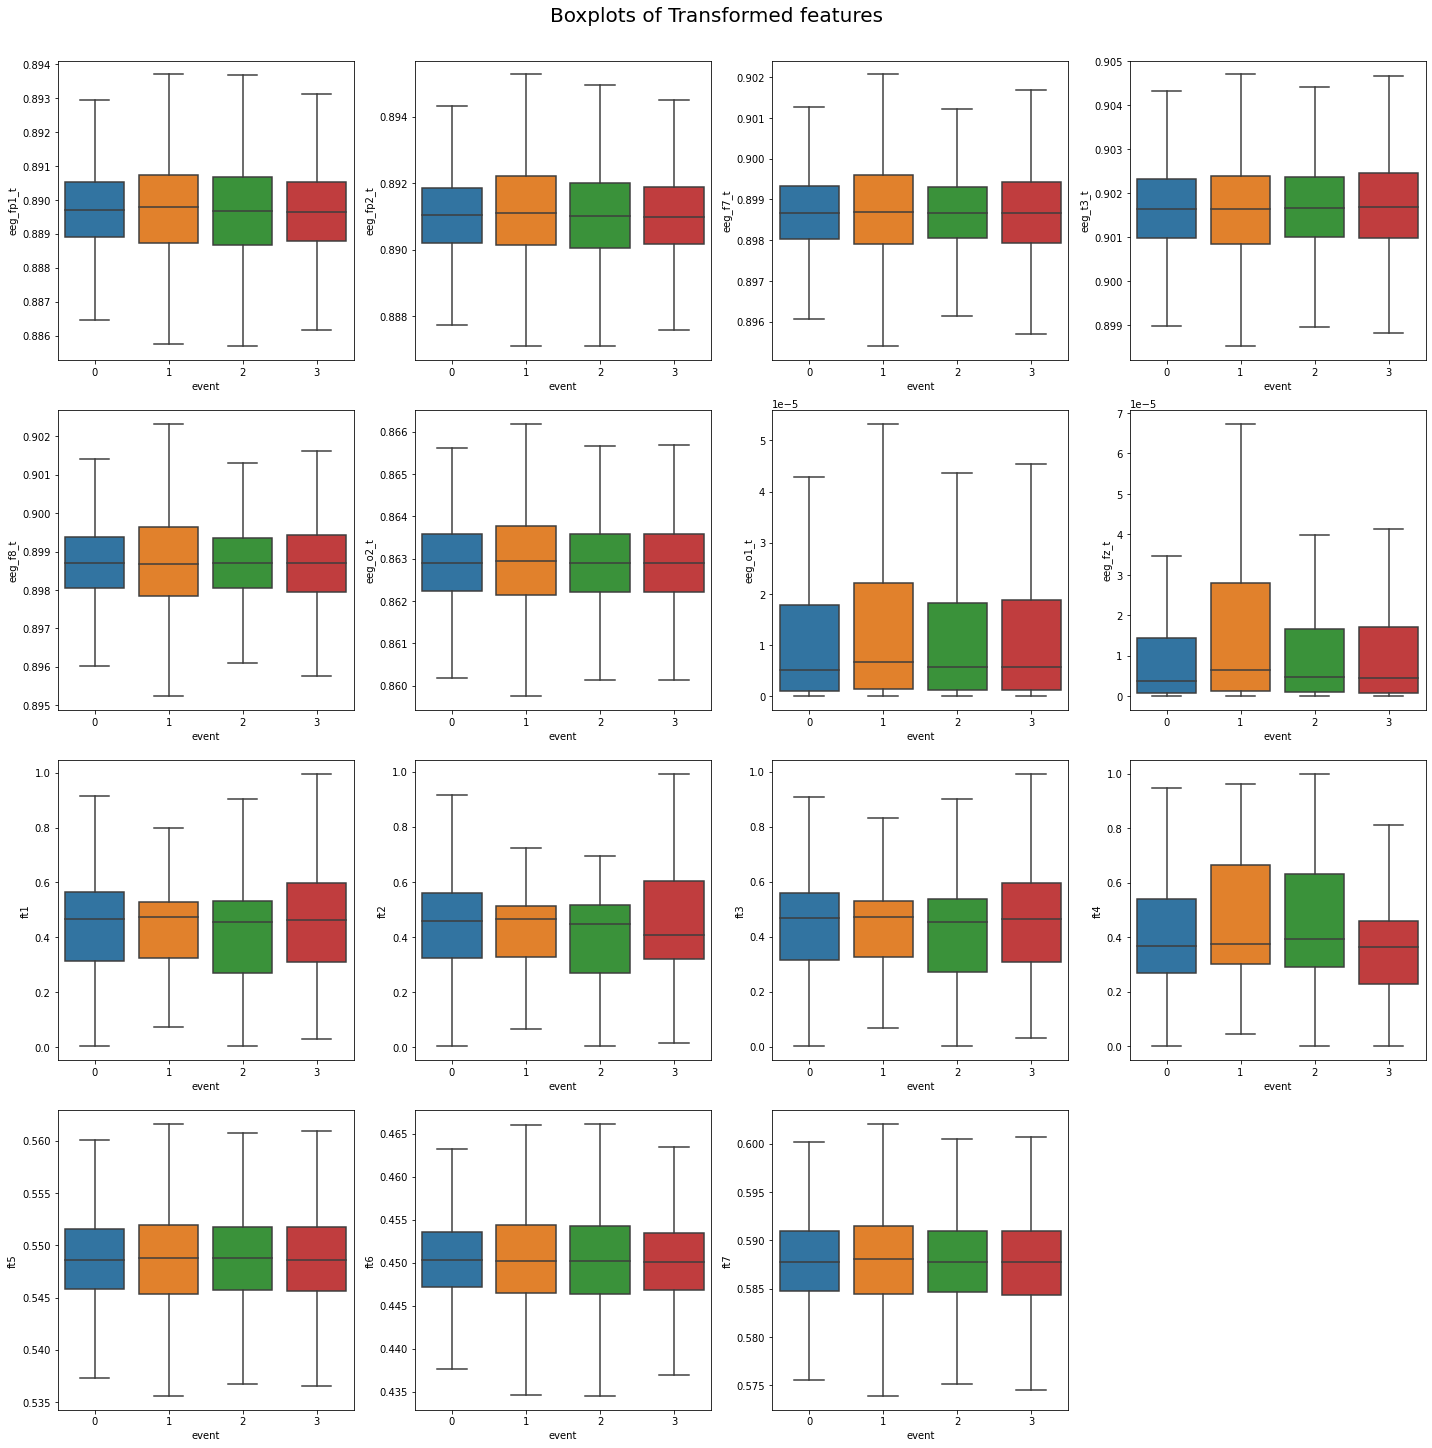

In [ ]:
fig = plt.figure(figsize=(20,25))
i = 0
                                                 # taking 50000 samples 
for eeg in new_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.boxplot(x='event', y=eeg, data=Ntrain.sample(50000), showfliers=False)
    plt.tight_layout()

fig.subplots_adjust(top=0.95)
fig.suptitle('Boxplots of Transformed features',fontsize=20)


plt.show()



boxplots of transformed features 

observations:   ft2 ,ft3 separates classc and classD .ft4 separates class B and class D.eeg_fz_t,eeg_o1_t usefull in classifying class B. log transforms of features  not at all usefull 

conclusion : some combinations ft3,ft2,ft4,ft1,eef_fz_t,eeg_o1_t some what usefull separating 


##**Feature Engineering**

**outliers-detection**

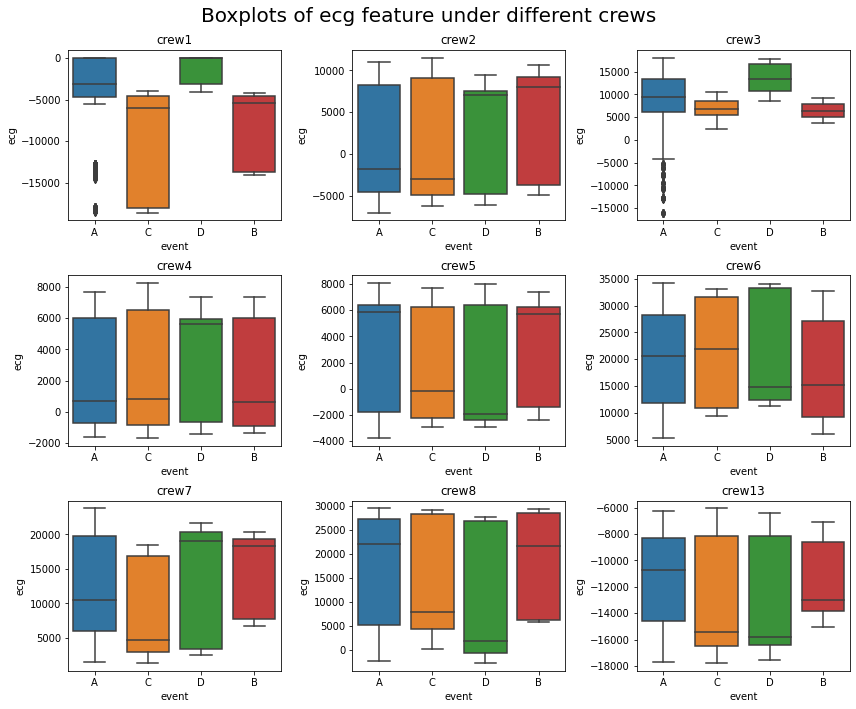

In [ ]:
fig = plt.figure(figsize=(12,10))                                                                         # out liers distribution under each crew 
for i,c in enumerate(train_df.crew.unique()):
  plt.subplot(3,3,i+1)
  sns.boxplot(y=train_df[train_df.crew==c].ecg , x=train_df[train_df.crew==c].event)
  plt.title(f'crew{c}')
  plt.tight_layout()

fig.subplots_adjust(top=0.92)
fig.suptitle('Boxplots of ecg feature under different crews',fontsize=20)

plt.show() 

boxplots of ecg features under different crews

observations:  only crew1 and crew3 have outliers that to in class A(baseline-condition) 

conclusion : having outliers in (class A) baseline-condition doesn't impact much compared other classses. 



In [ ]:
!pip install biosppy 

     |████████████████████████████████| 85 kB 2.3 MB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95430 sha256=c1353d5b88435daad4de39dc484195c9c7348b8ae764518f819c018387541915
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
Successfully built biosppy


In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from scipy import signal
from biosppy.signals import ecg 
from biosppy.signals import eeg                                   # biosppy imports
from biosppy.signals import resp 
from scipy.interpolate import interp1d 


###***Butter-Features***

In [ ]:
def noise_free(data,w):

  ''' function takes raw  signal and removes some noise present init gives noise free signal''' 
  n=5
  b,a = signal.butter(n,w,fs=256)

  return signal.filtfilt(b,a,data)

In [ ]:
filt_ecg = noise_free(train_df.ecg,100)                        # filtering ecg signal 
filt_resp = noise_free(train_df.r,0.7)                         # filtering respiratin signal 
train_df['filt_ecg'] = filt_ecg
train_df['filt_respiration'] = filt_resp

In [ ]:
filt_ecg = noise_free(test_df.ecg,100)
filt_resp = noise_free(test_df.r,0.7)
test_df['filt_ecg'] = filt_ecg                               
test_df['filt_respiration'] = filt_resp                       

###***Respiration-Rate***

In [ ]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html

def interpolation_fn(time,biosppy_ts, biosppy_values):
    """ linear interpolation function to produce heart rate all time steps

      x and y are arrays of values used to approximate some function f: y = f(x). 
      This class returns a function whose call method uses interpolation to find the value of new points.
       
       x           : Respiration rate time axis reference (seconds)
       y           : 

       fill_value  : used extrapolate instead of nan 
       kind        : what is the kind of interpolation you want do.there are various types like ‘linear’, ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, or ‘next’

       extrapolate : extend by inferring unknown values from trends in the known data
       intrapolate : method of constructing (finding) new data points based on the range of a discrete set of known data points."""

       
    interpolation = interp1d(biosppy_ts,biosppy_values, kind="linear", fill_value="extrapolate") 
    
    return interpolation(time) 

In [ ]:

print(r_ca.keys()) 


['ts', 'filtered', 'zeros', 'resp_rate_ts', 'resp_rate']


In [ ]:
#https://biosppy.readthedocs.io/en/stable/biosppy.signals.html#biosppy.signals.resp.resp               # resp rate for train data

'''Process a raw Respiration signal and extract relevant signal features using default parameters'''

r_ca=resp.resp(train_df[train_df["experiment"]=="CA"]["r"],sampling_rate=256,show=False)
r_da=resp.resp(train_df[train_df["experiment"]=="DA"]["r"],sampling_rate=256,show=False) 
r_ss=resp.resp(train_df[train_df["experiment"]=="SS"]["r"],sampling_rate=256,show=False)

resp_ca=interpolation_fn(train_df[train_df["experiment"]=="CA"]["time"],r_ca["resp_rate_ts"],r_ca["resp_rate"]) 
resp_da=interpolation_fn(train_df[train_df["experiment"]=="DA"]["time"],r_da["resp_rate_ts"],r_da["resp_rate"])  
resp_ss=interpolation_fn(train_df[train_df["experiment"]=="SS"]["time"],r_ss["resp_rate_ts"],r_ss["resp_rate"]) 
resp_rate=np.concatenate((resp_ca,resp_da,resp_ss)) 

train_df['resp_rate'] = resp_rate 
  

In [ ]:
r_test = resp.resp(test_df['r'],sampling_rate=256,show=False)
resp_rate_test = interpolation_fn(test_df["time"],r_test["resp_rate_ts"],r_test["resp_rate"])            # restp rate for test data 
test_df['resp_rate'] = resp_rate_test

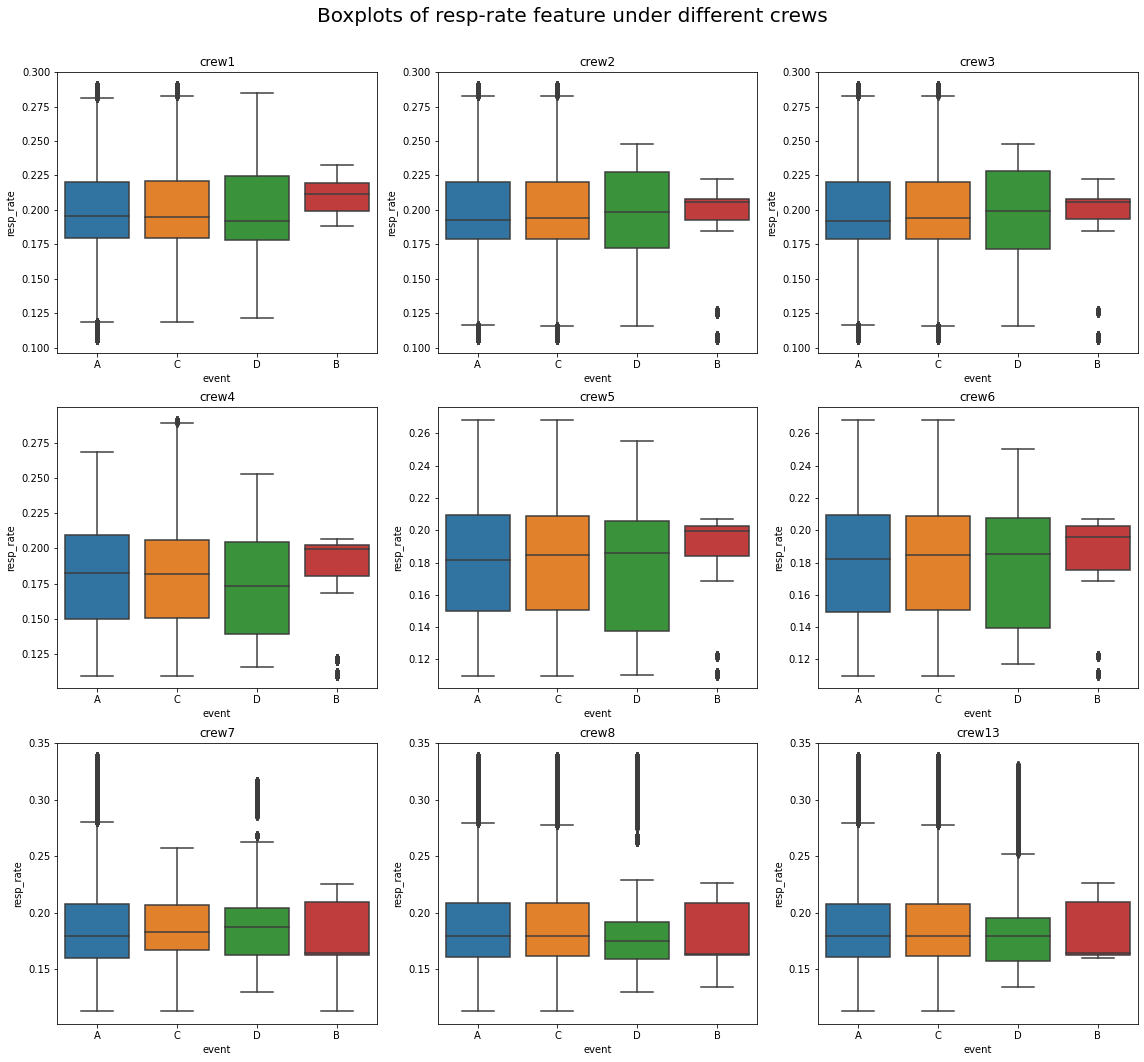

In [ ]:
fig = plt.figure(figsize=(16,15))
for i,c in enumerate(train_df.crew.unique()):
  plt.subplot(3,3,i+1)
  sns.boxplot(y=train_df[train_df.crew==c].resp_rate , x=train_df[train_df.crew==c].event)
  plt.title(f'crew{c}')
  plt.tight_layout()

fig.subplots_adjust(top=0.92) 
fig.suptitle('Boxplots of resp-rate feature under different crews',fontsize=20)

plt.show()

boxplots of resp-rate feature under different crews 

observation: there are outliers present in data in each crew except crew6. crew7 and crew8 have less outliers compared to other crews. crew7 ,crew8,crew13 have most outliers. in which class A and Class B have more contribution.

conclusion:  resp transforms of 'r' using biosspy have some outliers but we can't judge them not useful.

###***Heart-Rate***

In [ ]:
heart_rate = pickle.load(open('/content/drive/MyDrive/model/heart_rate.pkl','rb'))  # pickled heart rate for train data 

In [ ]:
#https://biosppy.readthedocs.io/en/stable/biosppy.signals.html#biosppy.signals.resp.resp

''' Process a raw ECG signal and extract relevant signal features using default parameters'''

ecg_ca = ecg.ecg(train_df[train_df["experiment"]=="CA"]["ecg"],sampling_rate=256,show=False)
ecg_da = ecg.ecg(train_df[train_df["experiment"]=="DA"]["ecg"],sampling_rate=256,show=False)               # for train data
ecg_ss = ecg.ecg(train_df[train_df["experiment"]=="SS"]["ecg"],sampling_rate=256,show=False)

heart_rate_ca=interpolation_fn(train_df[train_df["experiment"]=="CA"]["time"],ecg_ca["heart_rate_ts"],ecg_ca["heart_rate"])
heart_rate_da=interpolation_fn(train_df[train_df["experiment"]=="DA"]["time"],ecg_da["heart_rate_ts"],ecg_da["heart_rate"])
heart_rate_ss=interpolation_fn(train_df[train_df["experiment"]=="SS"]["time"],ecg_ss["heart_rate_ts"],ecg_ss["heart_rate"])

heart_rate=np.concatenate((heart_rate_ca,heart_rate_da,heart_rate_ss))  

train_df['heart_rate']  = heart_rate


In [ ]:
print(ecg_ca.keys()) # keys present in ecg.ecg 

['ts', 'filtered', 'rpeaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate']


In [ ]:
pickle.dump(ecg_rate_test, open('ecg_rate_test.pkl', 'wb' )) 
ecg_rate_test = pickle.load(open('/content/drive/MyDrive/model/ecg_rate_test.pkl','rb'))   # pickeled test data ecg rate for test data 

In [ ]:
ecg_test = ecg.ecg(test_df['ecg'],sampling_rate=256,show=False)
ecg_rate_test = interpolation_fn(test_df["time"],ecg_test["heart_rate_ts"],ecg_test["heart_rate"])         # for test data
test_df['heart_rate'] = ecg_rate_test[0] 

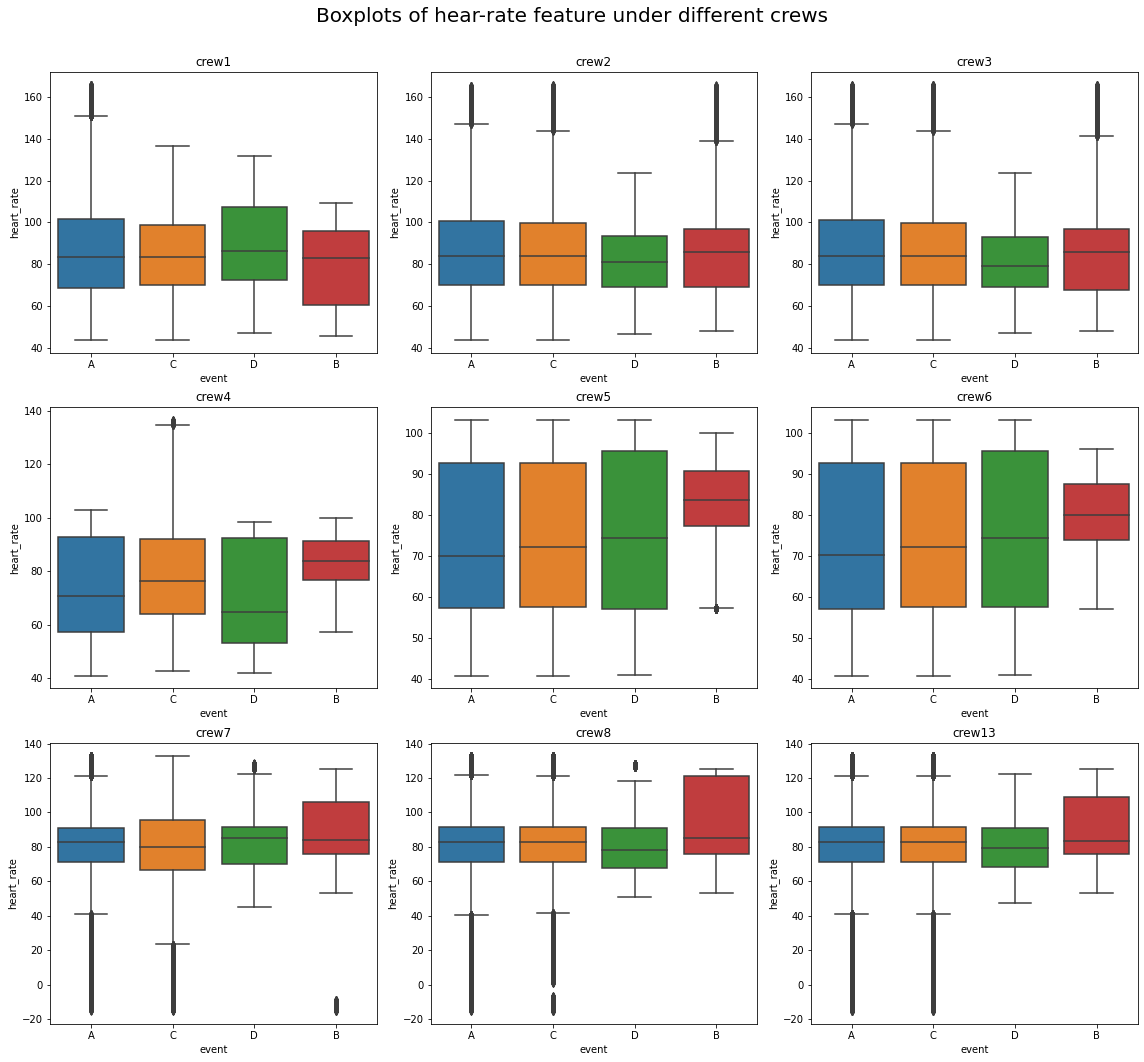

In [ ]:
fig = plt.figure(figsize=(16,15))
for i,c in enumerate(train_df.crew.unique()):
  plt.subplot(3,3,i+1)
  sns.boxplot(y=train_df[train_df.crew==c].heart_rate , x=train_df[train_df.crew==c].event)
  plt.title(f'crew{c}')
  plt.tight_layout() 

fig.subplots_adjust(top=0.92)
fig.suptitle('Boxplots of hear-rate feature under different crews',fontsize=20)


plt.show()


boxplots of heart-rate feature under different crews 

observation: there are outliers present in data in each crew except crew6. crew7 and crew8 have less outliers compared to other crews. crew7 ,crew8,crew13 have most outliers. in which class A and Class B have more contribution.

conclusion:  ecg transforms have some outliers but we can't judge them not useful.

###***Potential Differences of EEG*** 

This data is prepared in a fairly typical arrangement of 20 electrodes across the scalp. The letter in each lead signifies the part of the brain that that lead is nearest to (Temporal, Frontal, Parietal etc), with odd numbers on the left, evens on the right. Usually in the clinic, we don't look at the electrical potentials at each electrode, but at the potential difference between pairs of electrodes. This gives us an idea of the electrical field in the brain region between these two points as a way to infer what the brain is doing in that region. Clearly you can choose any two electrodes and produce 20! different potential differences, but not all of those are going to be useful.
We talk about the layout of choosing the pairs of electrodes to compare potential differences as Montages. There's lots of different montage systems, but commonly there's the 10-20 system. This data has an additional 'poz' electrode to the diagram, but that doesn't cause us a problem.

For this experiment, I chose the middle montage because it's one that's used clinically and I'm familiar with. Perhaps there's better ones for this experiment!
To montage the data, you just have to subtract the value of one electrode from another. It doesn't matter which way you do it, as long as it's consistent. I did this from front to back.

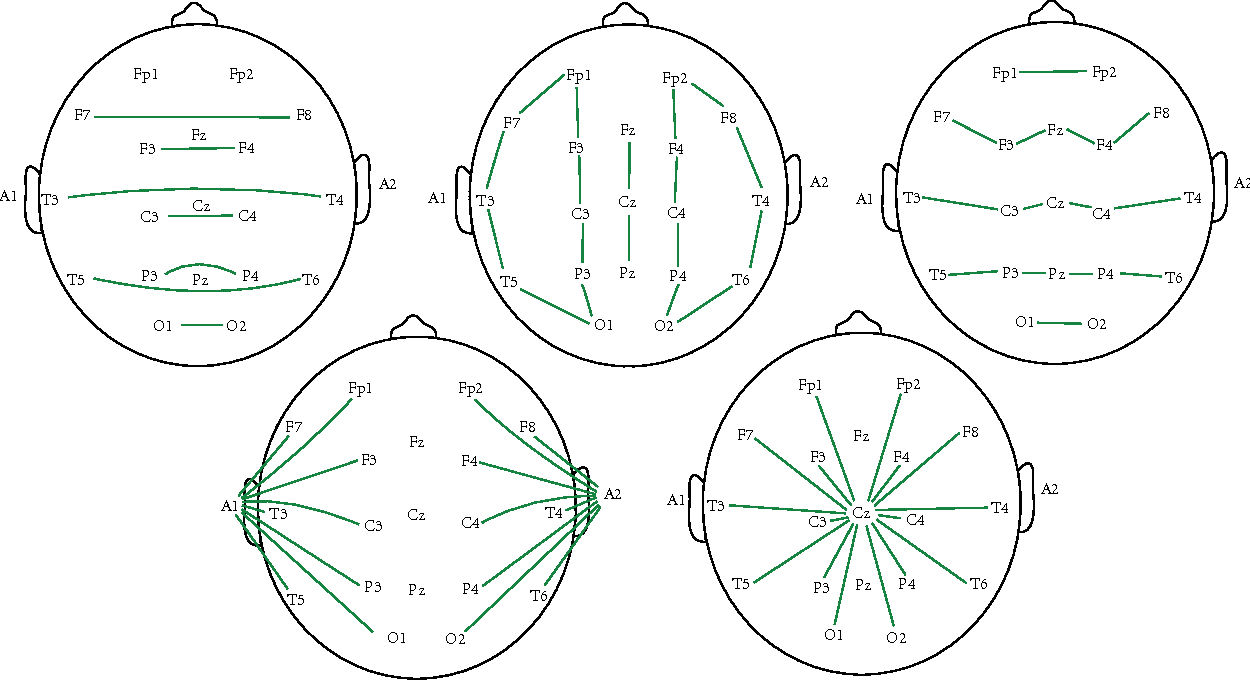

In [ ]:
train_df['fp1_f7'] = train_df['eeg_fp1'] - train_df['eeg_f7']
train_df['f7_t3'] = train_df['eeg_f7'] - train_df['eeg_t3']
train_df['t3_t5'] = train_df['eeg_t3'] - train_df['eeg_t5']
train_df['t5_o1'] = train_df['eeg_t5'] - train_df['eeg_o1']
train_df['fp1_f3'] = train_df['eeg_fp1'] - train_df['eeg_f7']
train_df['f3_c3'] = train_df['eeg_f3'] - train_df['eeg_c3']
train_df['c3_p3'] = train_df['eeg_c3'] - train_df['eeg_p3']
train_df['p3_o1'] = train_df['eeg_p3'] - train_df['eeg_o1']

train_df['fz_cz'] = train_df['eeg_fz'] - train_df['eeg_cz']
train_df['cz_pz'] = train_df['eeg_cz'] - train_df['eeg_pz']                     # train potential differences 
train_df['pz_poz'] = train_df['eeg_pz'] - train_df['eeg_poz']

train_df['fp2_f8'] = train_df['eeg_fp2'] - train_df['eeg_f8']
train_df['f8_t4'] = train_df['eeg_f8'] - train_df['eeg_t4']
train_df['t4_t6'] = train_df['eeg_t4'] - train_df['eeg_t6']
train_df['t6_o2'] = train_df['eeg_t6'] - train_df['eeg_o2']
train_df['fp2_f4'] = train_df['eeg_fp2'] - train_df['eeg_f4']
train_df['f4_c4'] = train_df['eeg_f4'] - train_df['eeg_c4']
train_df['c4_p4'] = train_df['eeg_c4'] - train_df['eeg_p4']
train_df['p4_o2'] = train_df['eeg_p4'] - train_df['eeg_o2']



In [ ]:
test_df['fp1_f7'] = test_df['eeg_fp1'] - test_df['eeg_f7']
test_df['f7_t3'] = test_df['eeg_f7'] - test_df['eeg_t3']
test_df['t3_t5'] = test_df['eeg_t3'] - test_df['eeg_t5']
test_df['t5_o1'] = test_df['eeg_t5'] - test_df['eeg_o1']
test_df['fp1_f3'] = test_df['eeg_fp1'] - test_df['eeg_f7']
test_df['f3_c3'] = test_df['eeg_f3'] - test_df['eeg_c3']                         # test potential differences 
test_df['c3_p3'] = test_df['eeg_c3'] - test_df['eeg_p3']
test_df['p3_o1'] = test_df['eeg_p3'] - test_df['eeg_o1']

test_df['fz_cz'] = test_df['eeg_fz'] - test_df['eeg_cz']
test_df['cz_pz'] = test_df['eeg_cz'] - test_df['eeg_pz']
test_df['pz_poz'] = test_df['eeg_pz'] - test_df['eeg_poz']

test_df['fp2_f8'] = test_df['eeg_fp2'] - test_df['eeg_f8']
test_df['f8_t4'] = test_df['eeg_f8'] - test_df['eeg_t4']
test_df['t4_t6'] = test_df['eeg_t4'] - test_df['eeg_t6']
test_df['t6_o2'] = test_df['eeg_t6'] - test_df['eeg_o2']                   
test_df['fp2_f4'] = test_df['eeg_fp2'] - test_df['eeg_f4']
test_df['f4_c4'] = test_df['eeg_f4'] - test_df['eeg_c4']
test_df['c4_p4'] = test_df['eeg_c4'] - test_df['eeg_p4']
test_df['p4_o2'] = test_df['eeg_p4'] - test_df['eeg_o2']

In [ ]:
train_df.memory_usage().sum() / 1024**2

566.3164005279541

In [ ]:
train_df.fp1_f3.dtypes

dtype('float16')

##**train_test_split**

In [ ]:
dic1 = {'A':0,'B':1,'C':2,'D':3}                    # labeling event classes as 0,1,2,3
train_df["event"] = train_df["event"].map(dic1) 
X = train_df.drop('event',axis=1) 
y = train_df['event']  

In [ ]:
# derived features 

features_n = ['fp1_f7', 'f7_t3', 't3_t5', 't5_o1', 'fp1_f3', 'f3_c3', 'c3_p3', 'p3_o1', 'fz_cz', 'cz_pz',
                'pz_poz', 'fp2_f8', 'f8_t4', 't4_t6', 't6_o2', 'fp2_f4', 'f4_c4', 'c4_p4', 'p4_o2', 'resp_rate','heart_rate', "gsr",'filt_ecg','filt_respiration']  


# raw features 

features_raw = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4",  
            "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2", "ecg", "r", "gsr"] 
            


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[features_n], y,test_size=0.20,stratify=y,random_state=1001)  # train_test split

##**mechine-learning-models**

###***Random-Model***

In [ ]:
predicted_y = np.zeros((len(y_test),1))                                                                      # random model 
for i in range(len(y_test)):
    rand_class = np.random.randint(0,3)
    predicted_y[i] = rand_class
print("macro f1-score on Test Data using Random Model",f1_score(y_test, predicted_y,average='macro'))
print("micro f1-score on Test Data using Random Model",f1_score(y_test, predicted_y,average='micro'))
print("weighted f1-score on Test Data using Random Model",f1_score(y_test, predicted_y,average='weighted'))

macro f1-score on Test Data using Random Model 0.20305037725891031
micro f1-score on Test Data using Random Model 0.31786998625967244
weighted f1-score on Test Data using Random Model 0.36484885750620044


###***Logistic-Regression*** 

In [ ]:
std=MinMaxScaler()                                                                                                 # scaling


In [ ]:
features=["ecg","r","gsr","resp_rate","heart_rate",'filt_respiration','filt_ecg']
for fea in tqdm(features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████| 7/7 [00:00<00:00, 20.35it/s]


In [ ]:
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8','eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3','eeg_pz', 'eeg_f3',
              'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz','eeg_c3', 'eeg_cz', 'eeg_o2']
for fea in tqdm(eeg_features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████| 20/20 [00:00<00:00, 29.44it/s]


In [ ]:
potential_difference=["fp1_f7","f7_t3","t3_t5","t5_o1","p3_o1","c3_p3","f3_c3","fp1_f3","fz_cz",
"cz_pz","fp2_f4","f4_c4","c4_p4","p4_o2","t6_o2","t4_t6","f8_t4","fp2_f8"]
for fea in tqdm(potential_difference):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████| 18/18 [00:00<00:00, 29.93it/s]


In [ ]:
LR = LogisticRegression(penalty='l2',C=0.001,max_iter=1000)                                             # logistic regression models 
LR.fit(X_train[features_n],y_train)

LogisticRegression(C=0.001, max_iter=1000)

In [ ]:
pickle.dump(LR, open('/content/drive/MyDrive/LinearRegression.pkl', 'wb' )) 
LR  = pickle.load(open('/content/drive/MyDrive/model/LinearRegression.pkl','rb')) 

In [ ]:
y_test_LR = LR.predict(X_test[features_n])  
print('cross-valid  weighted-f1 score is ',f1_score(y_test,y_test_LR,average='weighted'))
print('cross-valid  macro-f1 score is ',f1_score(y_test,y_test_LR,average='macro'))
print('cross-valid  micro-f1 score is ',f1_score(y_test,y_test_LR,average='micro'))                                                # 
print('croos-valid  log-loss score is ',log_loss(y_test,LR.predict_proba(X_test[features_n])))
print('cross valid  roc_auc score  is ',roc_auc_score(y_test,LR.predict_proba(X_test[features_n]),multi_class='ovr'))

cross-valid  weighted-f1 score is  0.2838646923295279
cross-valid  macro-f1 score is  0.18189008336354273
cross-valid  micro-f1 score is  0.22417032089252964
croos-valid  log-loss score is  26.550882645995273
cross valid  roc_auc score  is  0.501616238954811


TRAIN DATA CONFUSION MATRIX


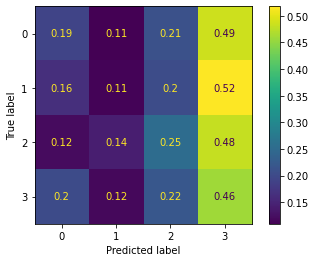

In [ ]:
print("TRAIN DATA CONFUSION MATRIX")
ConfusionMatrixDisplay.from_estimator(LR,X_train[features_n],y_train,normalize="true") ;           # train data confusion matrix
 

TEST DATA CONFUSION MATRIX


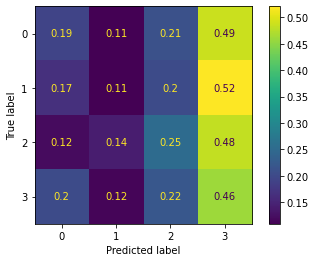

In [ ]:
print("TEST DATA CONFUSION MATRIX")
ConfusionMatrixDisplay.from_estimator(LR,X_test[features_n],y_test,normalize="true") ;        # validation data confusion matrix

from confusion matricies of train and test we can understand class3 classified well compared to others

###***Decision-Tree***

In [ ]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train[features_n],y_train)                                                

DecisionTreeClassifier()

In [ ]:
pickle.dump(DTC, open('/content/drive/MyDrive/decisiontree.pkl', 'wb' )) 
DTC  = pickle.load(open('/content/drive/MyDrive/decisiontree.pkl','rb'))

In [ ]:
y_test_DTC = DTC.predict(X_test[features_n])  
print('cross-valid  weighted-f1 score is ',f1_score(y_test,y_test_DTC,average='weighted'))
print('cross-valid  macro-f1 score is ',f1_score(y_test,y_test_DTC,average='macro'))                              # metrics check on validation data 
print('cross-valid  micro-f1 score is ',f1_score(y_test,y_test_DTC,average='micro'))
print('croos-valid  log-loss score is ',log_loss(y_test,DTC.predict_proba(X_test[features_n])))
print('cross valid  roc_auc score  is ',roc_auc_score(y_test,DTC.predict_proba(X_test[features_n]),multi_class='ovr'))

cross-valid  weighted-f1 score is  0.9844702728860453
cross-valid  macro-f1 score is  0.9779740735908815
cross-valid  micro-f1 score is  0.9844714575923528
croos-valid  log-loss score is  0.5363368539566196
cross valid  roc_auc score  is  0.9852456752980546


TRAIN DATA CONFUSION MATRIX


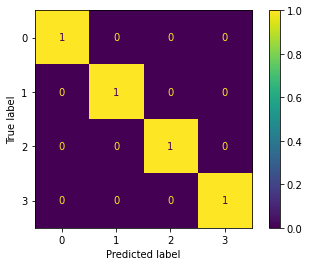

In [ ]:
print("TRAIN DATA CONFUSION MATRIX")
ConfusionMatrixDisplay.from_estimator(DTC,X_train[features_n],y_train,normalize="true") ;

TEST DATA CONFUSION MATRIX


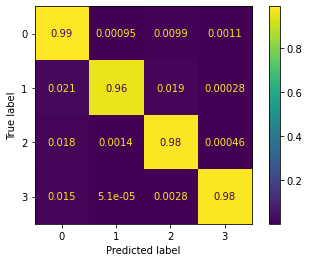

In [ ]:
print("TEST DATA CONFUSION MATRIX")
ConfusionMatrixDisplay.from_estimator(DTC,X_test[features_n],y_test,normalize="true") ;

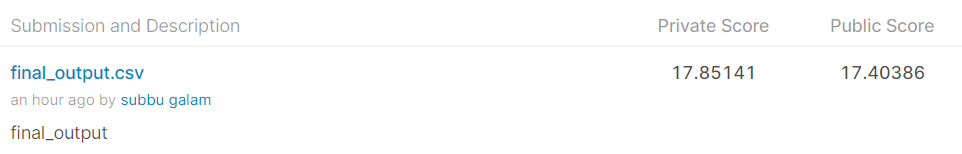

In [ ]:
  # kaggle
Image('/content/sc1.3.PNG') 

decision tree performance is good with train and validation data but performed very bad with real test data. we can understand that test data is very different compared to train data 

###***Random-Forest***

In [ ]:
RF = RandomForestClassifier(n_estimators=50)
RF.fit(X_train[features_n],y_train)

RandomForestClassifier(n_estimators=50)

In [ ]:
pickle.dump([RF], open('randomforest.pkl', 'wb' )) 
RF= pickle.load(open('/content/drive/MyDrive/randomforest.pkl','rb')) 
RF=RF[0]

In [ ]:
y_test_RF = RF.predict(X_test[features_n])  
print('cross-valid  weighted-f1 score is ',f1_score(y_test,y_test_RF,average='weighted'))
print('cross-valid  macro-f1 score is ',f1_score(y_test,y_test_RF,average='macro'))                             # metrics check on validation data 
print('cross-valid  micro-f1 score is ',f1_score(y_test,y_test_RF,average='micro'))
print('croos-valid  log-loss score is ',log_loss(y_test,RF.predict_proba(X_test[features_n])))
print('cross valid  roc_auc score  is ',roc_auc_score(y_test,RF.predict_proba(X_test[features_n]),multi_class='ovr'))

cross-valid  weighted-f1 score is  0.9842189289609691
cross-valid  macro-f1 score is  0.9626751001646401
cross-valid  micro-f1 score is  0.9844451603147785
croos-valid  log-loss score is  0.12008223413713152
cross valid  roc_auc score  is  0.9996930067585743


TRAIN DATA CONFUSION MATRIX


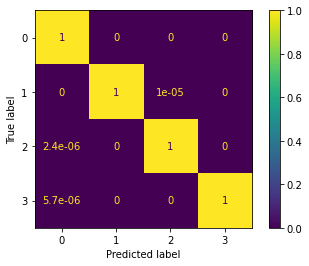

In [ ]:
print("TRAIN DATA CONFUSION MATRIX")
ConfusionMatrixDisplay.from_estimator(RF,X_train[features_n],y_train,normalize="true") ;

TEST DATA CONFUSION MATRIX


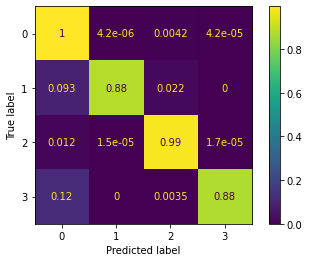

In [ ]:
print("TEST DATA CONFUSION MATRIX")
ConfusionMatrixDisplay.from_estimator(RF,X_test[features_n],y_test,normalize="true") ;

confusion matricies of train and validation data are very good . but it doesn't mean it works well on test data very well .

###***XG-boost***

**hyper-parameter-tuning**

In [ ]:
params = {
            
        "n_estimators":[10,20,30,50,100],          
        "num_leaves" : range(1,50),          
        "learning_rate" : [1e-4,0.0001,0.001,0.01,0.1],     
        "bagging_fraction" : list(np.arange(0.0,1.0,0.1)),                     # params for hyper parameter tuneing
        "colsample_bytree" : list(np.arange(0.0,1.0,0.1)),  
        'min_data_in_leaf':[1,10,20,50,80,100]

         
          }

In [ ]:
%%time
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
xgbc= xgb.XGBClassifier(tree_method='gpu_hist')
RS_xgb =RandomizedSearchCV(estimator=xgbc,param_distributions=params,n_jobs=-1,cv=skf.split(X_train[features_n],y_train),verbose=10,n_iter=1,random_state=1001)

CPU times: user 114 ms, sys: 1.13 ms, total: 115 ms
Wall time: 116 ms


In [ ]:
%%time
RS_xgb.fit(X_train[features_n],y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 50.4 s, sys: 2.25 s, total: 52.7 s
Wall time: 2min 34s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fc53d043e50>,
                   estimator=XGBClassifier(tree_method='gpu_hist'), n_iter=1,
                   n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                          

In [ ]:
RS_xgb.best_params_

{'bagging_fraction': 0.4,
 'colsample_bytree': 0.6000000000000001,
 'learning_rate': 0.01,
 'min_data_in_leaf': 10,
 'n_estimators': 30,
 'num_leaves': 41}

In [ ]:
best_params={'bagging_fraction': 0.4,
 'colsample_bytree': 0.6000000000000001,
 'learning_rate': 0.01,
 'min_data_in_leaf': 10,
 'n_estimators': 30,
 'num_leaves': 41}

**xgboost with tuning**

In [ ]:
xgbc_best =xgb.XGBClassifier(objective="multiclass",num_classes=4,metric="multi_logloss",**best_params,tree_method='gpu_hist')
xgbc_best.fit(X_train[features_n],y_train)


XGBClassifier(bagging_fraction=0.4, colsample_bytree=0.6000000000000001,
              learning_rate=0.01, metric='multi_logloss', min_data_in_leaf=10,
              missing=nan, n_estimators=30, num_classes=4, num_leaves=41,
              objective='multi:softprob', tree_method='gpu_hist')

In [ ]:
pickle.dump(xgbc_best, open('/content/drive/MyDrive/xgbc_best.pkl', 'wb' ))  
xgbc_best= pickle.load(open('/content/drive/MyDrive/model/xgbc_best.pkl','rb'))

**performance-metrics**

In [ ]:
y_test_xgb = xgbc_best.predict(X_test[features_n])  
print('cross-valid  weighted-f1 score is ',f1_score(y_test,y_test_xgb,average='weighted')) 
print('cross-valid  macro-f1 score is ',f1_score(y_test,y_test_xgb,average='macro'))                                              # performance metrics check on validation data 
print('cross-valid  micro-f1 score is ',f1_score(y_test,y_test_xgb,average='micro'))
print('croos-valid  log-loss score is ',log_loss(y_test,xgbc_best.predict_proba(X_test[features_n])))
print('cross valid  roc_auc score  is ',roc_auc_score(y_test,xgbc_best.predict_proba(X_test[features_n]),multi_class='ovr')) 


cross-valid  weighted-f1 score is  0.5650988795924645
cross-valid  macro-f1 score is  0.27891999007001017
cross-valid  micro-f1 score is  0.6400190326546444
croos-valid  log-loss score is  1.2198597687151478
cross valid  roc_auc score  is  0.7762229140686135


TRAIN DATA CONFUSION MATRIX


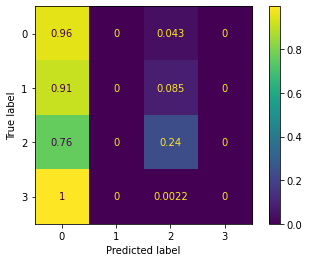

In [ ]:
print("TRAIN DATA CONFUSION MATRIX")
ConfusionMatrixDisplay.from_estimator(xgbc_best,X_train[features_n],y_train,normalize="true") ;        # train data confusion matrix

TEST DATA CONFUSION MATRIX


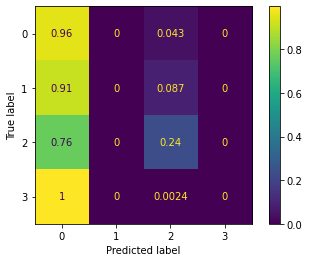

In [ ]:
print("TEST DATA CONFUSION MATRIX")                                                                     # validation data confusion matrix
ConfusionMatrixDisplay.from_estimator(xgbc_best,X_test[features_n],y_test,normalize="true") ; 

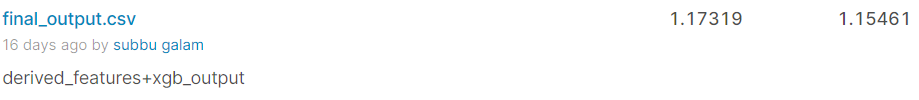

from both train and validation confusion matrix we can understand that model predicts classB&classD well but not classA&classC. model performance also better than decision tree.

###***LightGBM***

**hyper-parameter-tuning**

In [ ]:
params = {
    
        "n_estimators":[10,20,30,50,100],          
        "num_leaves" : range(1,50),          
        "learning_rate" : [1e-4,0.0001,0.001,0.01,0.1],     
        "bagging_fraction" : list(np.arange(0.0,1.0,0.1)),                     # params for finding hyper-parameters
        "colsample_bytree" : list(np.arange(0.0,1.0,0.1)),  
        'min_data_in_leaf':[1,10,20,50,80,100]
        
          }

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
lgbc=lgb.LGBMClassifier(tree_method='gpu_hist') 
RS_lgbm=RandomizedSearchCV(lgbc,param_distributions=params,verbose=10,n_jobs=-1,cv=skf.split(X_train[features_n],y_train),random_state=1001)


In [ ]:
%%time
RS_lgbm.fit(X_train[features_n],y_train)
 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1001, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/

CPU times: user 2min 13s, sys: 3.05 s, total: 2min 16s
Wall time: 23min 1s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7ff63e4c3750>,
                   estimator=LGBMClassifier(tree_method='gpu_hist'), n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000

In [ ]:
RS_lgbm.best_params_

{'bagging_fraction': 0.9,
 'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'min_data_in_leaf': 50,
 'n_estimators': 30,
 'num_leaves': 35}

**Light-gbm with tuning**

In [ ]:
params = {'bagging_fraction': 0.9,
 'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'min_data_in_leaf': 50,                                                                                                       # best params for lightgbm
 'n_estimators': 30,
 'num_leaves': 35} 

In [ ]:
clf_lgbm = lgb.LGBMClassifier(objective='multiclass',num_classes=4,metric='multi_logloss',**params)
clf_lgbm.fit(X_train[features_n],y_train) 

LGBMClassifier(bagging_fraction=0.9, colsample_bytree=0.9,
               metric='multi_logloss', min_data_in_leaf=50, n_estimators=30,
               num_classes=4, num_leaves=35, objective='multiclass')

In [ ]:
import pickle
pickle.dump(clf_lgbm, open('/content/drive/MyDrive/lightgbm.pkl', 'wb' ))  
clf_lgbm = pickle.load(open('/content/drive/MyDrive/model/lightgbm.pkl','rb')) 

**Performance-metrics**

In [ ]:
y_test_hat = clf_lgbm.predict(X_test[features_n]) 
print('cross-valid  weighted-f1 score is ',f1_score(y_test,y_test_hat,average='weighted'))                                            # performance check using different metrics on validataion data 
print('cross-valid  macro-f1 score is ',f1_score(y_test,y_test_hat,average='macro'))
print('cross-valid  micro-f1 score is ',f1_score(y_test,y_test_hat,average='micro'))

print('croos-valid  log-loss score is ',log_loss(y_test,clf_lgbm.predict_proba(X_test[features_n])))
print('cross valid  roc_auc score  is ',roc_auc_score(y_test,clf_lgbm.predict_proba(X_test[features_n]),multi_class='ovr'))



cross-valid  weighted-f1 score is  0.8384469125000882
cross-valid  macro-f1 score is  0.5869367224311637
cross-valid  micro-f1 score is  0.8617595545899526
croos-valid  log-loss score is  0.4081127057474934
cross valid  roc_auc score  is  0.9676287556623391


TRAIN DATA CONFUSION MATRIX


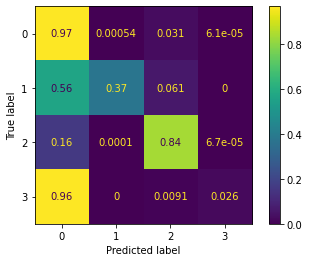

In [ ]:
print("TRAIN DATA CONFUSION MATRIX")                                                                  # train data confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_lgbm,X_train[features_n],y_train,normalize="true") ;

TEST DATA CONFUSION MATRIX


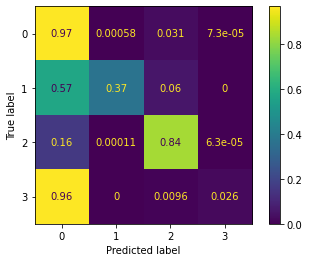

In [ ]:
print("TEST DATA CONFUSION MATRIX")                                                             # test data confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_lgbm,X_test[features_n],y_test,normalize="true") ;

**Feature-importance**

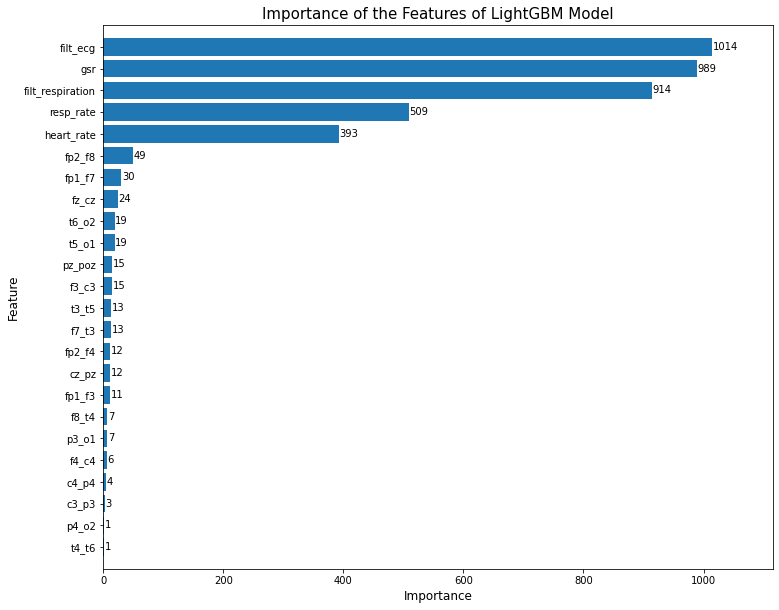

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(clf_lgbm, height=0.8, ax=ax)                                            # using derived features 
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of LightGBM Model", fontsize=15)
plt.show()

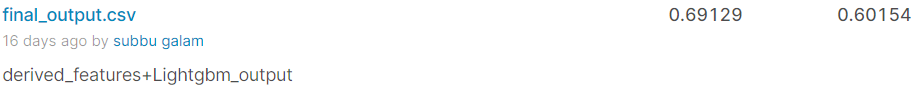

###***custom-stacking***

**hyper-tuning**

In [ ]:
xgbc =xgb.XGBClassifier() 
lgbm = lgb.LGBMClassifier()
logistic = LogisticRegression()
dtree = DecisionTreeClassifier(max_depth=20, min_samples_leaf=3, min_samples_split=5)          # all 6 models used in stacking
svm = SVC()
forest = RandomForestClassifier()


D = pd.concat([X_train,y_train],axis=1)
Dev = pd.concat([X_test,y_test],axis=1)
D1 = D[:1946968]
D2 = D[1946968:] 



def hyper_tune(D1,model):  # hyper tuner 

  ''' function which takes D1 data and models then work on hyper tuning and gives best of that model  '''
  data = resample(D1,replace=True,n_samples=len(D1)//2,random_state=1001) 
  class_label = 1
  y = data.event.apply(lambda x: 1 if x==class_label else 0)
  x = data[features_n] 
   
  if model == xgbc:
      
    params = {    
                
      "n_estimators":[10,20,30,50,100],          
      "num_leaves" : range(1,50),          
      "learning_rate" : [1e-4,0.0001,0.001,0.01,0.1],     
      "bagging_fraction" : list(np.arange(0.0,1.0,0.1)),                    
      "colsample_bytree" : list(np.arange(0.0,1.0,0.1)),  
      'min_data_in_leaf':[1,10,20,50,80,100]
              
        }  

    skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001) 
    
    RS_xgb =RandomizedSearchCV(estimator=xgbc,scoring='f1_macro',param_distributions=params,n_jobs=-1,cv=skf.split(x,y),n_iter=1,random_state=1001)
    RS_xgb.fit(x,y)
    return RS_xgb.best_params_


  elif model == lgbm :
    params = {    
                
      "n_estimators":[10,20,30,50,100],          
      "num_leaves" : range(1,50),          
      "learning_rate" : [1e-4,0.0001,0.001,0.01,0.1],     
      "bagging_fraction" : list(np.arange(0.0,1.0,0.1)),                    
      "colsample_bytree" : list(np.arange(0.0,1.0,0.1)),  
      'min_data_in_leaf':[1,10,20,50,80,100]
              
        }  

    skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001) 
    
    RS_lgbm =RandomizedSearchCV(estimator=lgbm,scoring='f1_macro',param_distributions=params,n_jobs=-1,cv=skf.split(x,y),n_iter=1,random_state=1001)
    RS_lgbm.fit(x,y)
    return RS_lgbm.best_params_



  elif model == logistic:
    
    LRparams = {
      'C': [0.001, 0.01, 0.1, 1],
      'penalty': ['l1', 'l2']   }
    skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
    RS_lr= RandomizedSearchCV(logistic,scoring='f1_macro',param_distributions=LRparams,cv=skf.split(x,y))  
    RS_lr.fit(x,y)
    return RS_lr.best_params_ 



  elif model ==svm:

    Svmparams = {
        'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'degree':[2,3,4,5],
              'kernel': ['rbf','poly']
    }

    skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
    RS_svm= RandomizedSearchCV(svm,scoring='f1_macro',param_distributions=Svmparams,cv=skf.split(x,y))  
    RS_svm.fit(x,y)
    return RS_svm.best_params_

  elif model == dtree:

    dparams = {
        'max_depth':[5,10,15,20],
        'min_samples_split':[5,10,15],
        'min_samples_leaf':[3,5,10,15] 
          }
    skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
    RS_dt= RandomizedSearchCV(dtree,scoring='f1_macro',param_distributions=dparams,cv=skf.split(x,y)) 
    RS_dt.fit(x,y)
    return RS_dt.best_params_ 
  

  elif model == forest:
    Rparams = {
        'n_estimators':[20,40,60,80],
        'max_depth':[10,15,20,25],
        'min_samples_split':[5,10,15],
        'min_samples_leaf':[3,5,10,15] } 
    skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
    RS_rf= RandomizedSearchCV(forest,scoring='f1_macro',param_distributions=Rparams,cv=skf.split(x,y)) 
    RS_rf.fit(x,y)
    return RS_rf.best_params_ 
        
    

In [ ]:
hyper_tune(D1,logistic)                         # logisic hyper params 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line

{'C': 0.001, 'penalty': 'l2'}

In [ ]:
hyper_tune(D1,dtree)  # decision tree hyper params 

{'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 5}

In [ ]:
hyper_tune(D1,xgbc)                                     # xgbc hyper params 

{'bagging_fraction': 0.4,
 'colsample_bytree': 0.6000000000000001,
 'learning_rate': 0.01,
 'min_data_in_leaf': 10,
 'n_estimators': 30,
 'num_leaves': 41}

In [ ]:
import gc                                               # to free some of garbage values
gc.collect()
gc.collect() 

0

In [ ]:
hyper_tune(D1,forest)                                   # random forest params 

{'max_depth': 25,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 80}

In [ ]:
hyper_tune(D1,svm)   # svm hyper params

{'C': 1, 'gamma': 1, 'kernel': 'poly'}

In [ ]:
                                                          # xgboost params 
xgbm_params = {'bagging_fraction': 0.4,
 'colsample_bytree': 0.6000000000000001,
 'learning_rate': 0.01,                       
 'min_data_in_leaf': 10,
 'n_estimators': 30,
 'num_leaves': 41}

In [ ]:
                                                          # lgbm params 
lgbm_params = {'bagging_fraction': 0.4,
 'colsample_bytree': 0.6000000000000001,                            
 'learning_rate': 0.01,
 'min_data_in_leaf': 10,
 'n_estimators': 30,
 'num_leaves': 41}

**stacking-classifier**

In [ ]:
%%time
D = pd.concat([X_train,y_train],axis=1)        # train concating after splitting 
Dev = pd.concat([X_test,y_test],axis=1)        # test concatination for Dev
D1 = D[:1946968]                              # D1 dataset (1/2)D
D2 = D[1946968:]                              # D2 dataset (1/2)D


                     # stacking of 3 models 

""" function which takes D1, D2 and Dev data then gives predicted-probabilites of Dev data  """
def stacking_classifer(D1,D2,Dev,k):
  class_label = ['A', 'B', 'C', 'D']

  xgbc =xgb.XGBClassifier(bagging_fraction=0.4,colsample_bytree = 0.6000000000000001,learning_rate = 0.01,min_data_in_leaf = 10,n_estimators=30,num_leaves=41)
  lgbm = lgb.LGBMClassifier(bagging_fraction=0.4,colsample_bytree = 0.6000000000000001,learning_rate = 0.01,min_data_in_leaf = 10,n_estimators=30,num_leaves=41)
  dtree = DecisionTreeClassifier(max_depth=20, min_samples_leaf=3, min_samples_split=5)
  svm = SVC(C=1, gamma= 1, kernel= 'poly')
  logistic = LogisticRegression(C= 0.001,penalty='l2',max_iter=1000) 
  forest = RandomForestClassifier(max_depth=25,min_samples_leaf=10,min_samples_split=5,n_estimators=80)

  models = [lgbm,xgbc,dtree,forest,logistic,svm] 
  test_predictions = np.zeros((len(Dev),len(class_label)))
  for c in range(len(class_label)):                                                                 # for each class A,B,C,D 

    meta_train_data = np.zeros((len(D2),k))
    meta_eval_data = np.zeros((len(Dev),k)) 
    for i in range(k):                                                                               # for each model

      data = resample(D1,replace=True,n_samples=len(D1)//3,random_state=1001) 
      y = data.event.apply(lambda x: 1 if x==class_label[c] else 0)
      x = data[features_n] 
      models[i].fit(x, y)
      meta_train_data[:,i] = models[i].predict(D2[features_n]).reshape(len(D2),)
      meta_eval_data[:,i] = models[i].predict(Dev[features_n]).reshape(len(Dev),) 
    
    y_meta = D2.event.apply(lambda x: 1 if x==class_label[c] else 0)
    log = LogisticRegression().fit(meta_train_data,y_meta)                                            # meta classifier 
    test_predictions[:,c]=log.predict_proba(meta_eval_data)[:,-1].reshape(len(Dev),)

  return test_predictions
# test_prob = stacking_classifer(D1,D2,Dev,2) 

CPU times: user 310 ms, sys: 8.72 ms, total: 319 ms
Wall time: 316 ms


In [ ]:
pickle.dump(D1, open('/content/drive/MyDrive/model/D1.pkl', 'wb' ))  
pickle.dump(D2, open('/content/drive/MyDrive/model/D2.pkl', 'wb' ))  
pickle.dump(test_df[features_n], open('/content/drive/MyDrive/model/test_df.pkl', 'wb' ))    # pickling temp variables 
D1 = pickle.load(open('/content/drive/MyDrive/model/D1.pkl','rb')) 
D2 = pickle.load(open('/content/drive/MyDrive/model/D2.pkl','rb')) 
test_df = pickle.load(open('/content/drive/MyDrive/model/test_df.pkl','rb')) 

In [ ]:
%%time 
pred_out1 = stacking_classifer(D1,D2,test_df[features_n][:4491285],5) 


CPU times: user 47min 11s, sys: 1min 13s, total: 48min 24s
Wall time: 46min 44s


In [ ]:
%%time
pred_out2 = stacking_classifer(D1,D2,test_df[features_n][4491285:2*4491285],5)

CPU times: user 48min 8s, sys: 1min 12s, total: 49min 21s
Wall time: 47min 51s


In [ ]:
%%time 
pred_out3 = stacking_classifer(D1,D2,test_df[features_n][2*4491285:3*4491285],5)

CPU times: user 50min, sys: 1min 14s, total: 51min 15s
Wall time: 49min 42s


In [ ]:
%%time
pred_out4 = stacking_classifer(D1,D2,test_df[features_n][3*4491285:],5)

CPU times: user 48min 55s, sys: 1min 15s, total: 50min 11s
Wall time: 48min 40s


In [ ]:
pred_test = np.concatenate((pred_out1,pred_out2,pred_out3,pred_out4),axis=0)          # stacking test predicted probabilites of each test set 

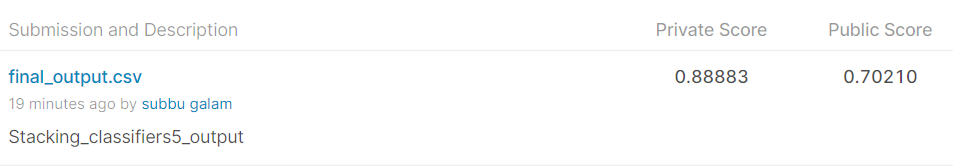

##**Submitting Predictions**

In [ ]:
pred_test1 = clf_lgbm.predict_proba(test_df[features_n][:4491285])  
pred_test2 = clf_lgbm.predict_proba(test_df[features_n][4491285:2*4491285])                # this is how test data got splitted into 4 parts 
pred_test3 = clf_lgbm.predict_proba(test_df[features_n][2*4491285:3*4491285])  
pred_test4 = clf_lgbm.predict_proba(test_df[features_n][3*4491285:])                       
pred_test = np.concatenate((pred_test1,pred_test2,pred_test3,pred_test4),axis=0)            


In [ ]:
# creating submission data frame 
submission = pd.DataFrame(np.concatenate((np.arange(len(test_df))[:, np.newaxis], pred_test), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
submission['id'] = submission['id'].astype(int) 


In [ ]:
submission.head()                                                             # stacking output head 

,id,A,B,C,D
0,0,0.328208,0.847558,0.571210,0.013247
1,1,0.950792,0.847558,0.022025,0.811014
2,2,0.950792,0.847558,0.571210,0.013247
3,3,0.950792,0.847558,0.022025,0.811014
4,4,0.950792,0.004374,0.571210,0.013247


In [ ]:
submission.to_csv('final_output.csv',index=False)                        # to csv from dataframe 

In [ ]:
#https://www.kaggle.com/getting-started/64061                            # using kaggle api for submission
                                                           
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f final_output.csv -m "Stacking_classifiers5_output" 

100% 1.49G/1.49G [00:14<00:00, 113MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

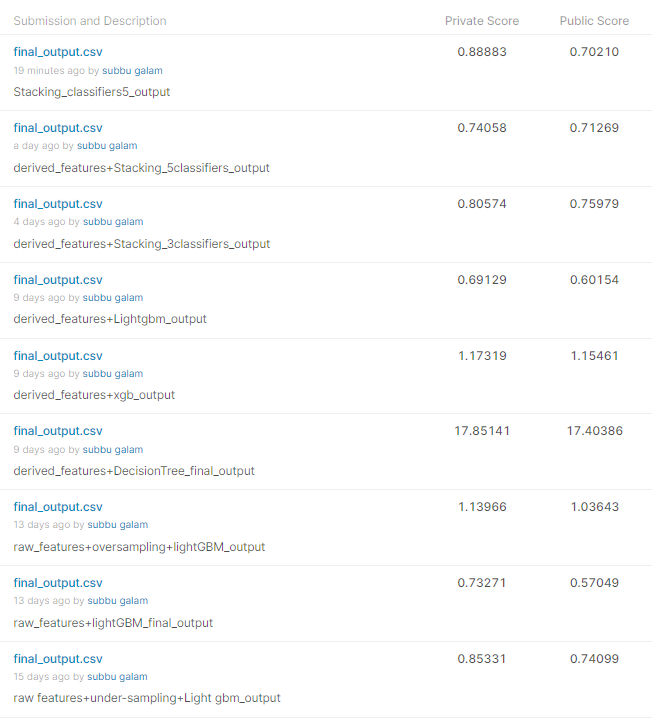

check submissions of total experiments i have done...